In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
# from matplotlib.colors import LogNorm
import numpy as np
import math as ma
from subprocess import call

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from scipy.io import readsav
from scipy.interpolate import interp1d
# from scipy.interpolate import interp2d

import extinction
import igm

import loadSP as lsp
import cosmo
import halos
# import logInterp 

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32
import gc

plt.rcParams.update({'font.size': 22, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')

def div_formatter(x,pos):
    return format(x, '.1f')

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)
divfmt  = FuncFormatter(div_formatter)
logfmt  = FuncFormatter(log_formatter)
nullfmt = NullFormatter()

In [42]:
# Cosmology from my paper
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.267, Ob0=0.0449, name='myCosmo')
comovingBox = 12.0 # per h

# Make sure we have halo information for this z... hop/...
num = 13 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.
z   = 18.0

prefix = '/Users/earnric/Research/RAMSES-Data/12Mpc-n.48-eps20/'

boxInMpc = (12.0 /0.71/(1.0+z)) * u.Mpc # Based on cosmology... 

boxsizekpc = boxInMpc.to(u.kpc)
print("Using cosmology: physical size  = {:.3f}".format(boxsizekpc))

# sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
# print("Physical Boxsize from kKey file = {:.3f}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))

boxInCm = (12.0 /0.71/(1.0+z)) * 3.08e24 * u.cm # Using RAMSES conversion factor
boxInKpc = boxInCm.to(u.kpc)
print("Using ramses const for Mpc to CM= {:.3f}:".format(boxInKpc) )


infoSize = lsp.getBoxSize(num,prefix) ### REMEMBER to Load from info_xxxx ###
print("Using info size, astro convert  = {:.3f}:".format((infoSize * u.cm).to(u.kpc)) )
print("Using info size, 3.08  (bad!)   = {:.3f}:".format(infoSize/(3.08e21/u.kpc)) )

#############################
## THIS IS THE MOST ACCURATE -- at least with respect to pynbody
#############################
boxsizekpc = (infoSize * u.cm).to(u.kpc).value

rho_critDMz = myCosmo.critical_density(z) * myCosmo.Odm(z)
print('rho_crit_dm,z = {:.3e}'.format(rho_critDMz))

gc.collect()

Using cosmology: physical size  = 889.548 kpc
Using ramses const for Mpc to CM= 887.911 kpc:
Using info size, astro convert  = 887.943 kpc:
Using info size, 3.08  (bad!)   = 889.580 kpc:
rho_crit_dm,z = 1.443e-26 g / cm3


4908

In [43]:
Odm = 0.222 # Om - Ob = Odm
h0  = 0.71
rho0 = myCosmo.critical_density0 * Odm # rho0 * O_DM --- Crit density in DM TODAY... Need to scale to redshift.
rho0/Odm
# Check critical density 'today' - Looks correct!

<Quantity 9.469372730554712e-30 g / cm3>

In [44]:
dmPartMass = 5.589e5 * u.Msun
print("DM particle mass {:.2f}".format(dmPartMass))
def totMass(numParts):
    return dmPartMass * numParts

DM particle mass 558900.00 solMass


In [45]:
locsRaw, mass, bt, Z, PZ, PPF = lsp.loadSP(z)
##############################################
# Need to correct the Z and PZ for the pristine
# fraction of the SP... 
##############################################
fpol = 1.0-PPF
fpol[fpol < 1e-5] = 0.0 # Don't form polluted stars when fpol is very small

Z_corr = Z/fpol
Z_corr[np.isinf(Z_corr)] = 0.9e-5 # Make the Z of the particles < Z_crit (1e-5)
Z_corr[Z_corr < 1e-5]    = 0.9e-5 # Place them all just below Z_crit
gc.collect()
locsRaw.size

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide


12963

In [46]:
# Convert to comoving kpc ... we've divided out the h here so we have units of kpc
locs = (locsRaw/boxsizekpc) * comovingBox # Comoving coords of SPs 

In [47]:
# Compute age of the star particles...
# spAges is in Myr ... 

baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
print("base age {:.2f}".format(baseAge))
spAges = baseAge - bt/1e6    # bt from SP file is in yr, convert to Myr... 
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.3e} Solar".format(min(Z)))
print("max sp Z {:.4f} Solar".format(max(Z)))
print("max sp Z {:.4f} mass frac".format(max(Z) * 0.02))

base age 214.67
min sp age 0.94 Myr
max sp age 62.13 Myr
min sp Z 5.000e-09 Solar
max sp Z 0.1227 Solar
max sp Z 0.0025 mass frac


In [48]:
arcPerKpc = myCosmo.arcsec_per_kpc_comoving(z=z)
print('Comoving @ {}, {:.4f}:'.format(z,arcPerKpc))
arcPerKpc = myCosmo.arcsec_per_kpc_proper(z=z)
print('Proper to {}, {:.4f}:'.format(z,arcPerKpc))
print('Proper to {}, {:.4f}:'.format(z,1/arcPerKpc))

kpcPerArcSec = cosmo.arcAtz(71,z=z,om=0.267) # size of an arcsec at the specified reshift in kpc
print('My Comoving @ {}, {:.4f}:'.format(z,arcPerKpc/(1+z)))
print('My Proper to {}, {:.4f}:'.format(z,arcPerKpc))
print('My Proper to {}, {:.4f}:'.format(z,1/arcPerKpc))

Comoving @ 18.0, 0.0190 arcsec / kpc:
Proper to 18.0, 0.3604 arcsec / kpc:
Proper to 18.0, 2.7744 kpc / arcsec:
My Comoving @ 18.0, 0.0190 arcsec / kpc:
My Proper to 18.0, 0.3604 arcsec / kpc:
My Proper to 18.0, 2.7744 kpc / arcsec:


In [49]:
myCosmo.age(z)

<Quantity 0.21281553257074565 Gyr>

In [91]:
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
## Scale locations to co-moving coordates

## THESE HALOS ARE BASED ON STAR PARTICLE LOCATIONS ##
##
prefix = '/Users/earnric/Research/RAMSES-Data/12Mpc-n.48-eps20/12Mpc-n.48-eps20-output/'
prefix = '/Users/earnric/Research/RAMSES-Data/12Mpc-n.48-eps20/'
halosRawPos = lsp.loadHaloGrps(num,prefix=prefix+'hopStarData2/') # Returns positions normalized to (-0.5, 0.5)
halossizes = lsp.loadHaloSizes(num,prefix=prefix+'hopStarData2/') # Returns positions normalized to (-0.5, 0.5)
# halosRawPos = lsp.loadHaloGrps(num) # Returns positions normalized to (-0.5, 0.5)
# halossizes = lsp.loadHaloSizes(num) # Returns positions normalized to (-0.5, 0.5)

#halosPos = halosRawPos * boxsizekpc
halosPos = halosRawPos * comovingBox  # Comoving box 
print("Num of halos @ {} = {}".format(z,len(halosRawPos)))

Num of halos @ 18.0 = 34


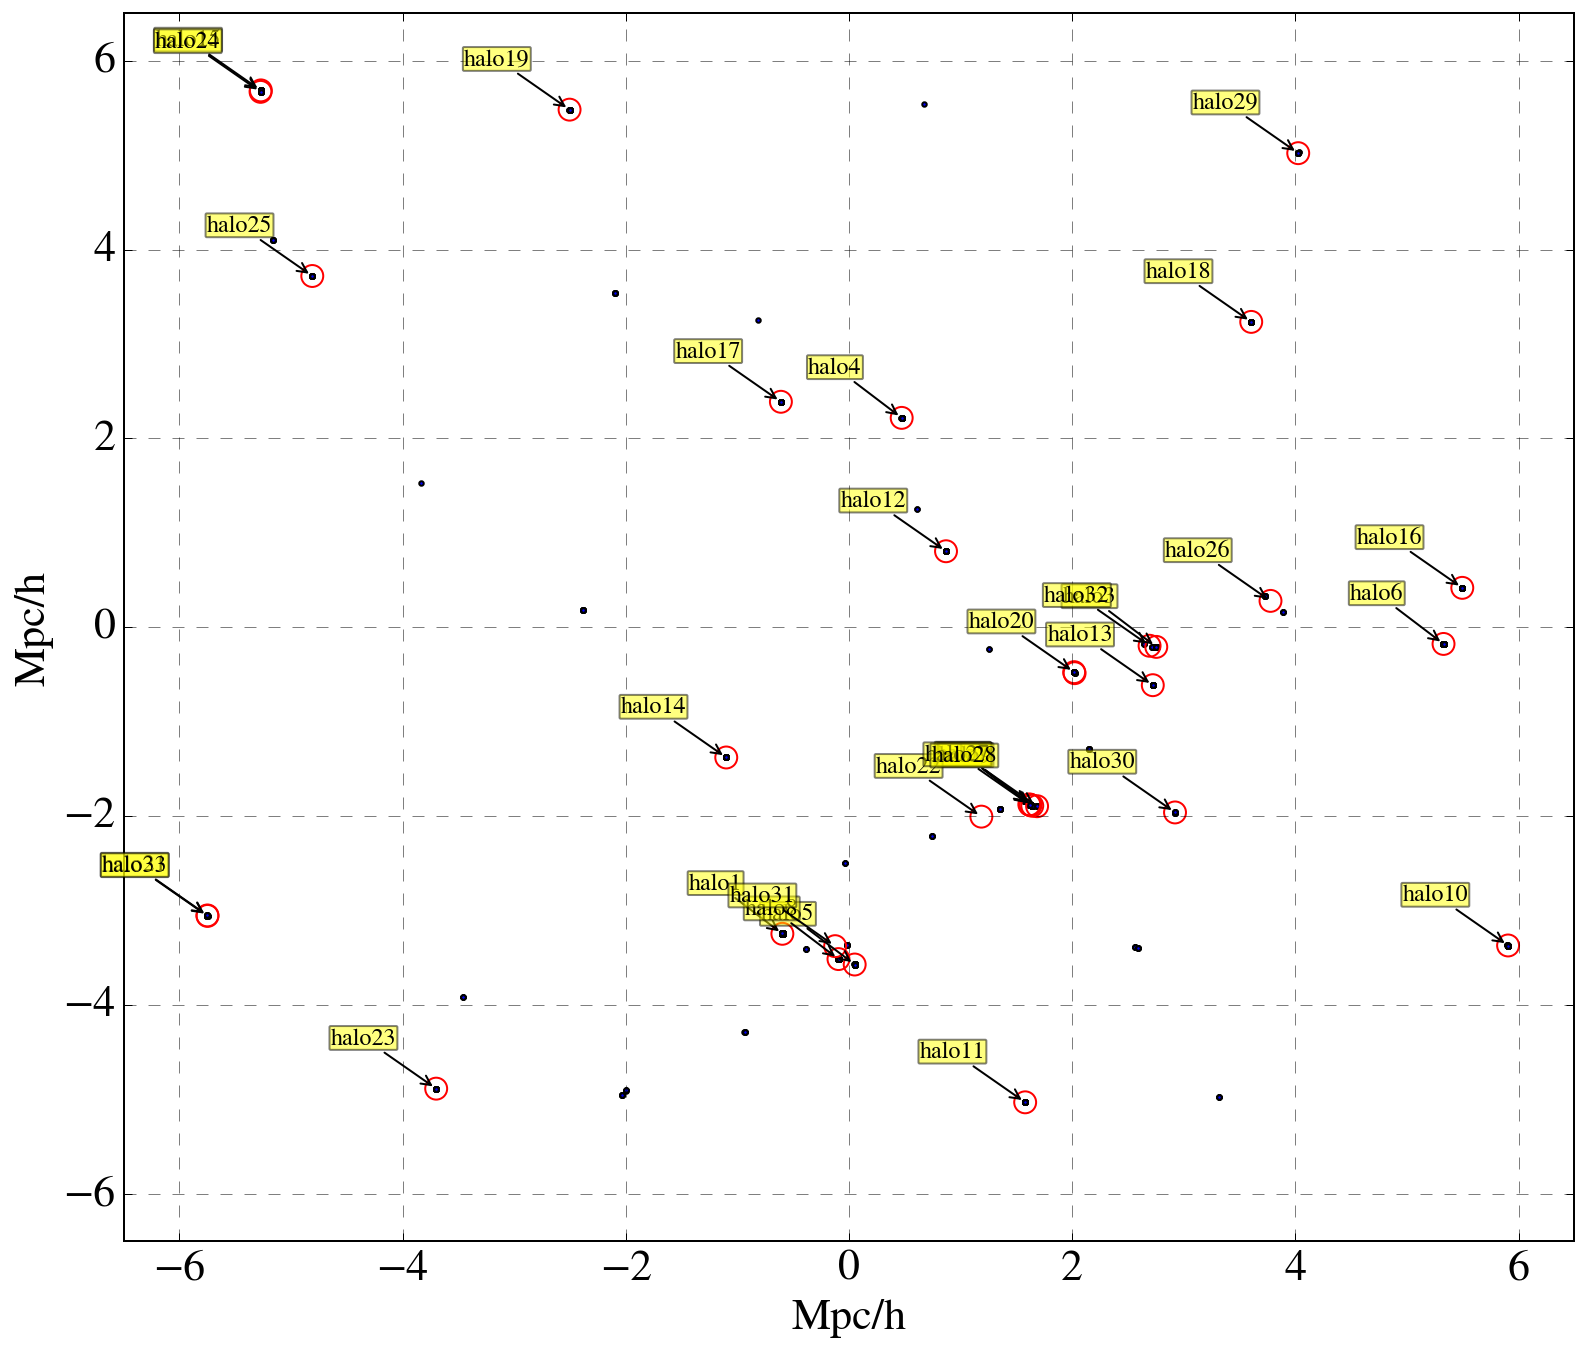

11164

In [92]:
# COORDINATES ARE COMOVING MPC / H
htp = min(100,len(halosRawPos))
labels = ['halo{0}'.format(i+1) for i in range(len(halosPos))]
plt.scatter(locs[:,0],locs[:,1],s=5,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0],halosPos[:htp,1],s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='k', linestyle='--',alpha=0.5)
plt.xlabel('Mpc/h')
plt.ylabel('Mpc/h')
plt.xlim([-6.5,6.5])
plt.ylim([-6.5,6.5])
# plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,0][:33],halosPos[:htp,1][:33]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=12,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

arc sec/kpc = 0.019
radius 10.00
Halo mass 0 is 7.39e+06
Halo mass 1 is 3.27e+06
Halo mass 2 is 1.42e+06
Halo mass 3 is 8.44e+05
Halo mass 4 is 5.26e+05
Halo mass 5 is 4.99e+05
Halo mass 6 is 0.00e+00
Halo mass 7 is 3.95e+05
Halo mass 8 is 3.45e+05
Halo mass 9 is 3.06e+05
Halo mass 10 is 2.65e+05
Halo mass 11 is 2.57e+05
Halo mass 12 is 1.75e+05
Halo mass 13 is 1.61e+05
Halo mass 14 is 1.65e+05
Halo mass 15 is 1.60e+05
Halo mass 16 is 1.57e+05
Halo mass 17 is 1.47e+05
Halo mass 18 is 1.49e+05
Halo mass 19 is 1.40e+05
Halo mass 20 is 1.34e+05


/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Halo mass 21 is 0.00e+00
Halo mass 22 is 0.00e+00
Halo mass 23 is 1.01e+05
Halo mass 24 is 9.08e+04
Halo mass 25 is 9.04e+04
Halo mass 26 is 0.00e+00
Halo mass 27 is 8.26e+04


787

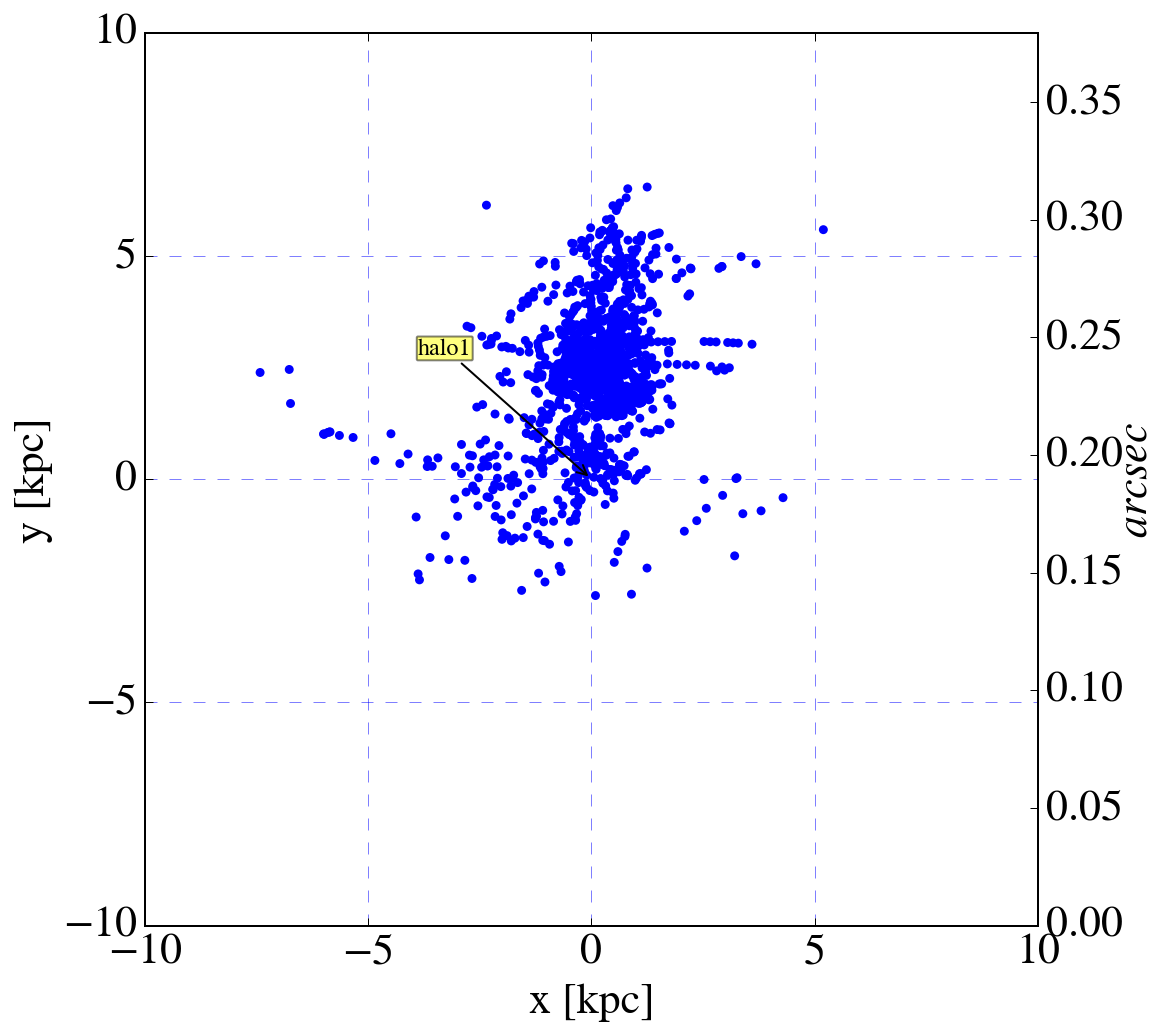

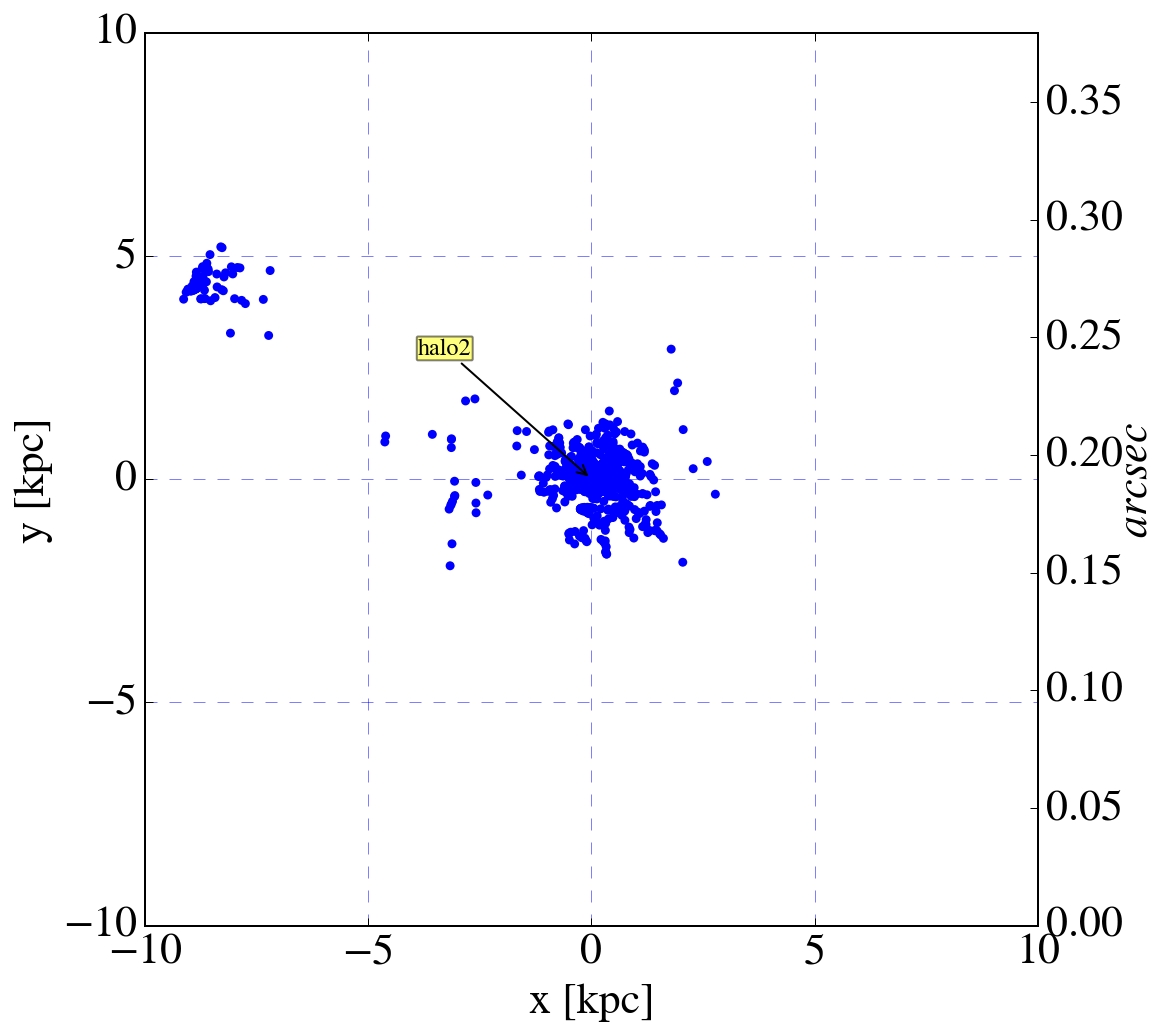

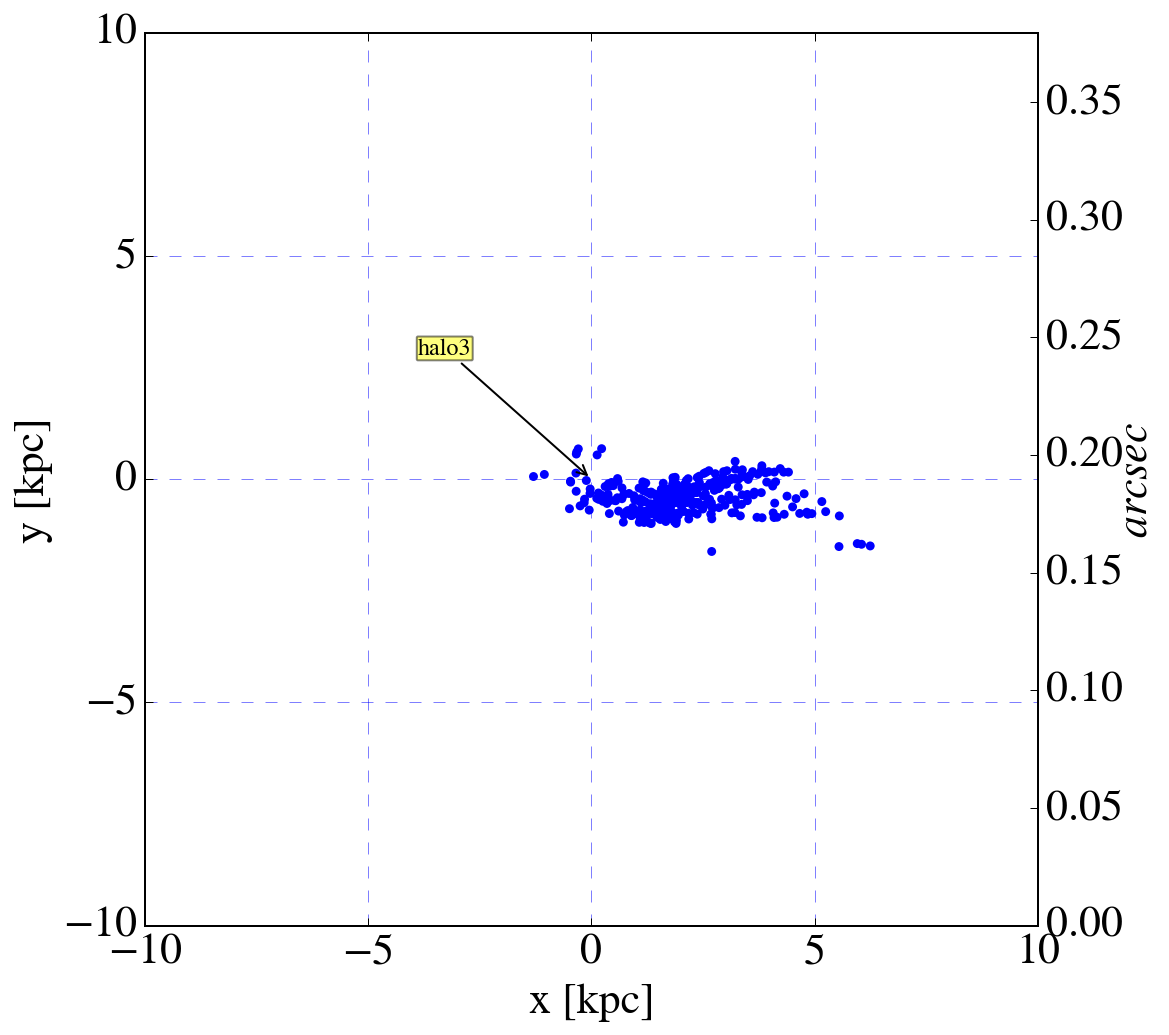

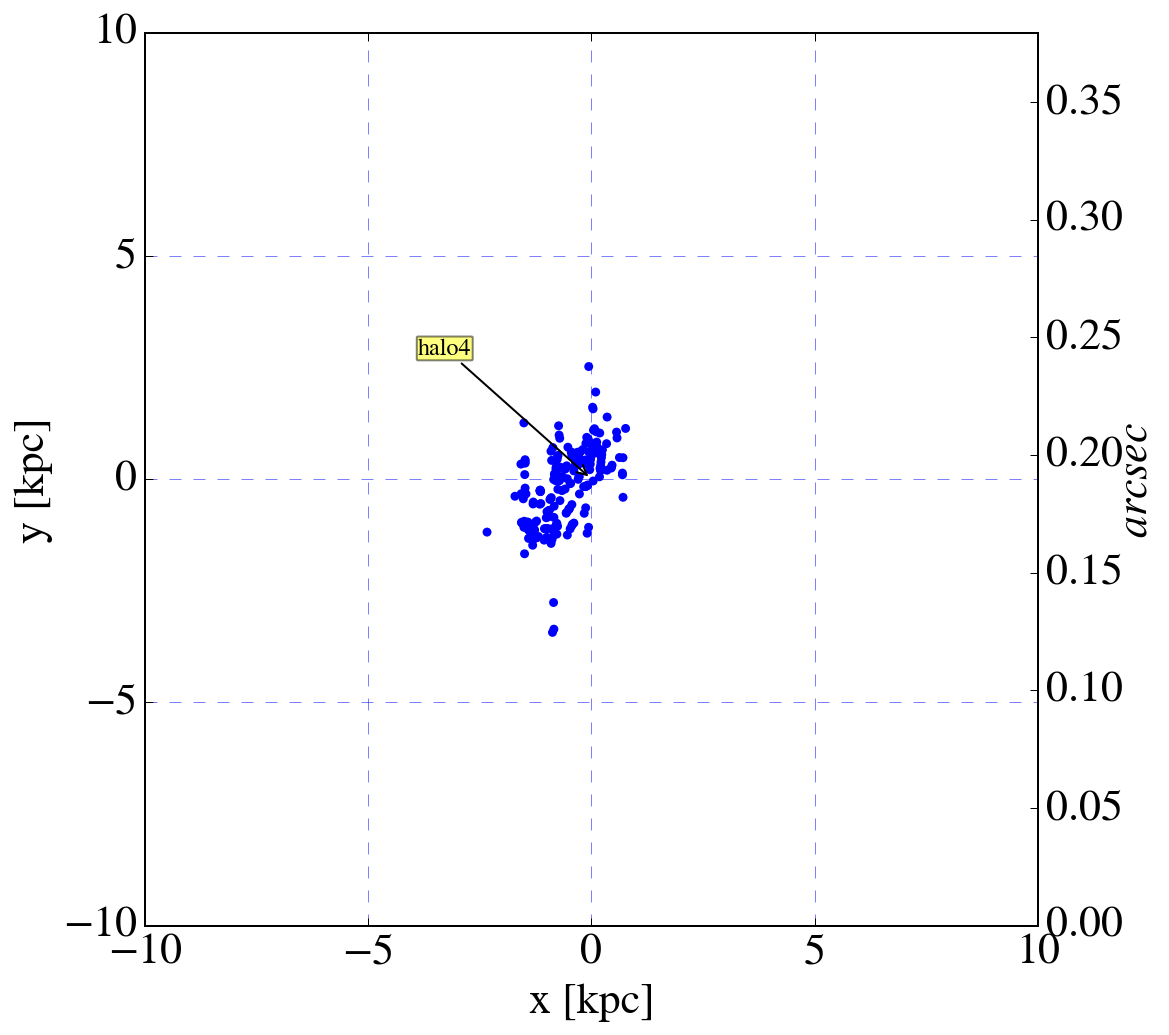

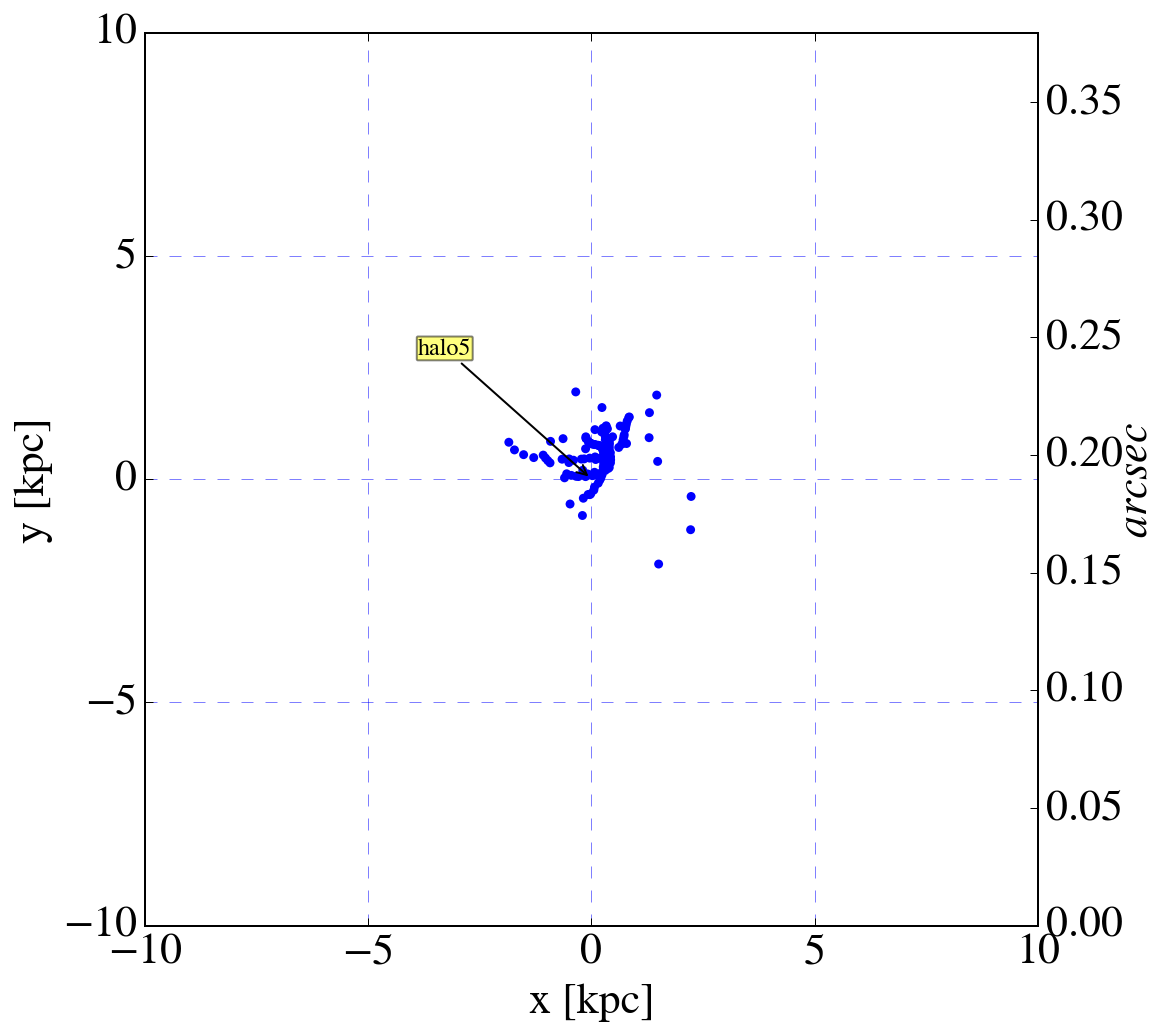

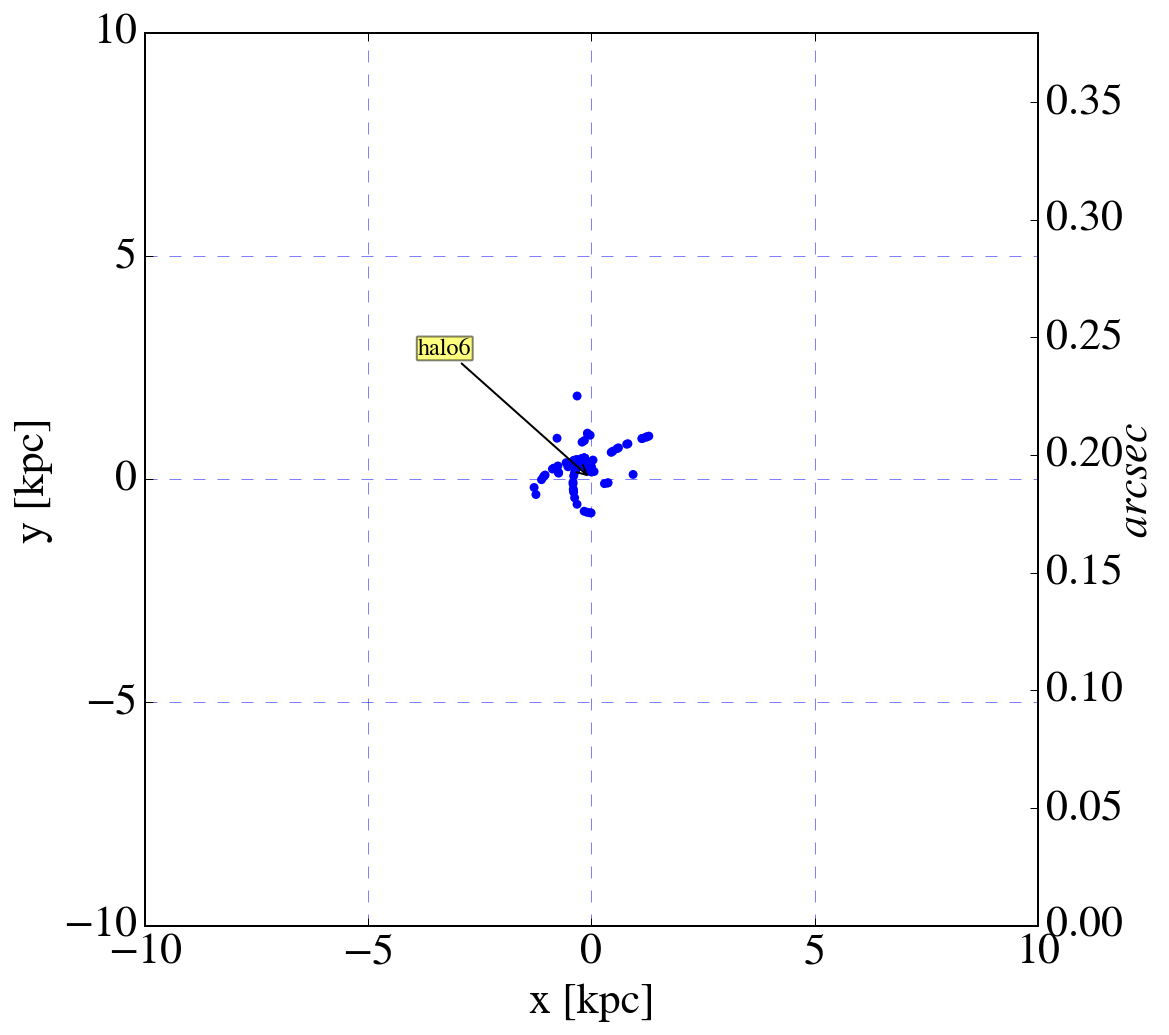

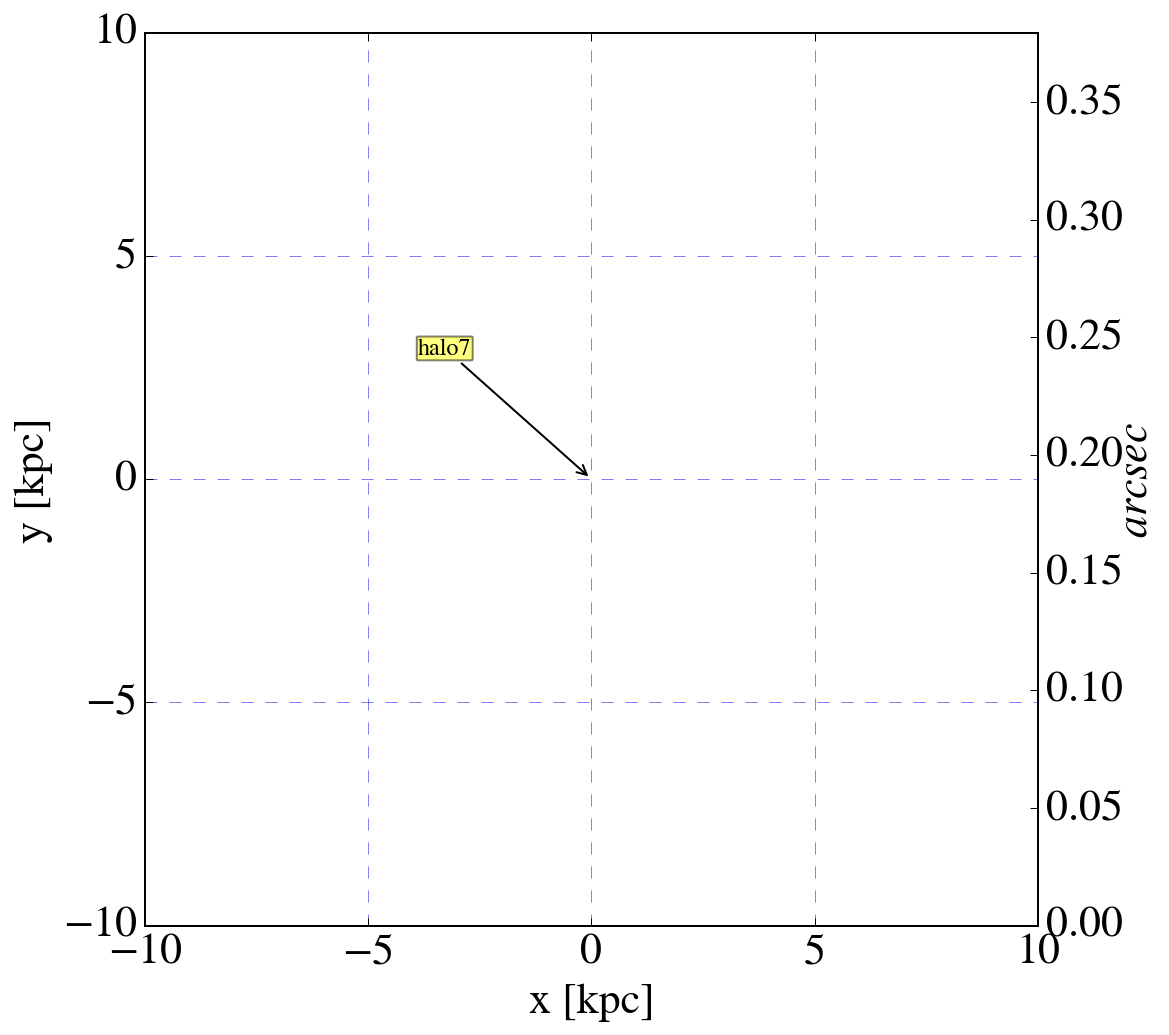

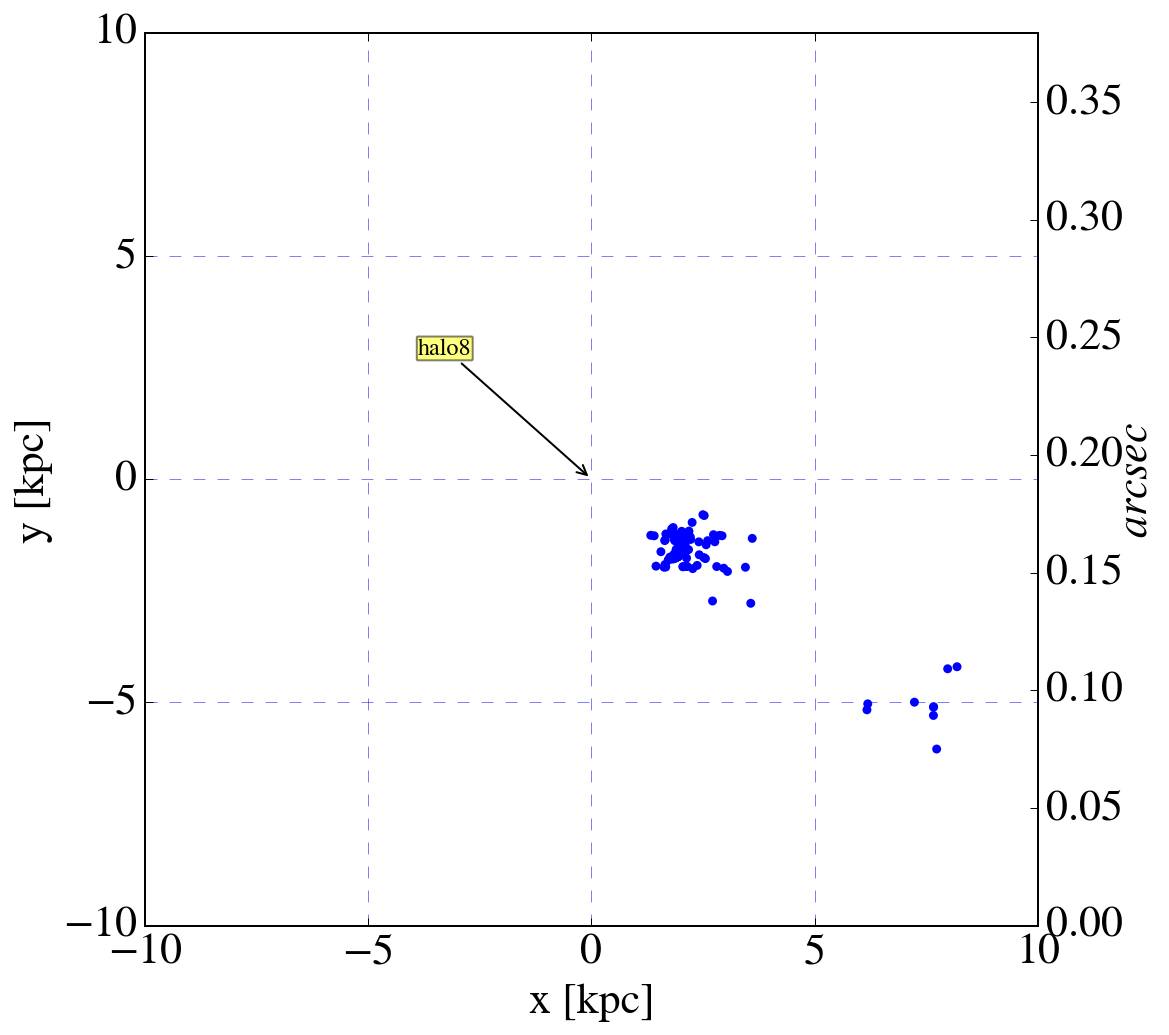

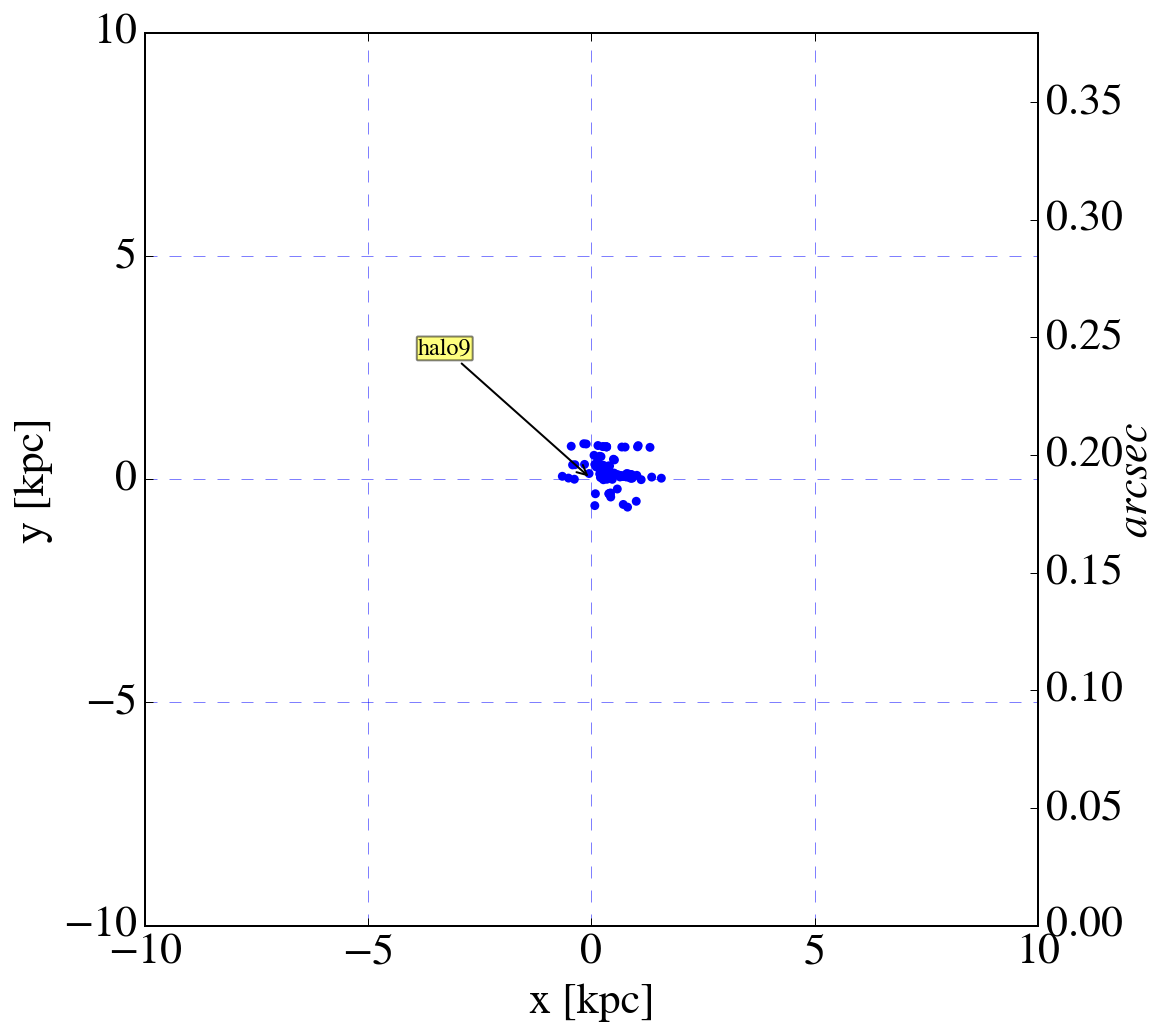

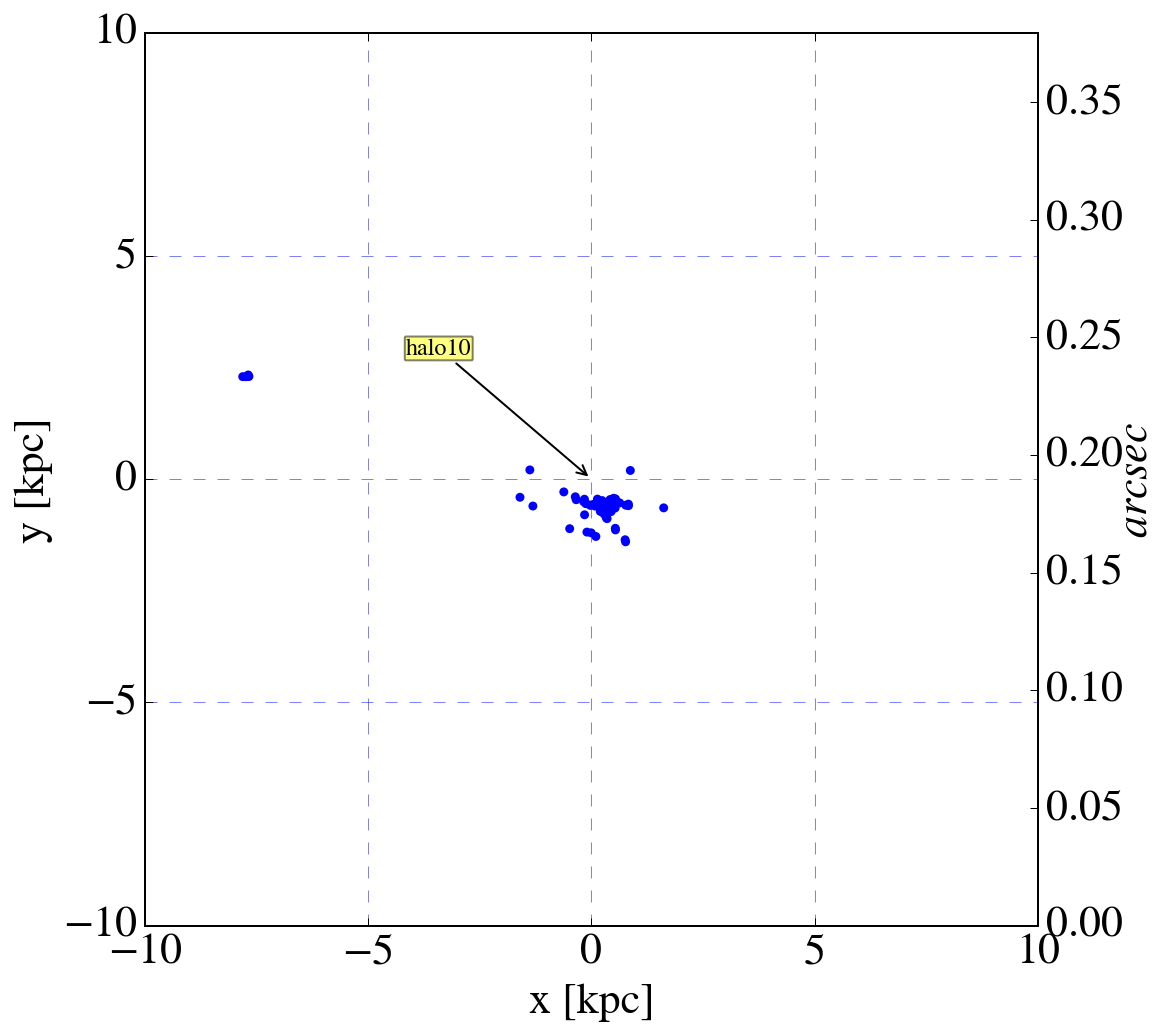

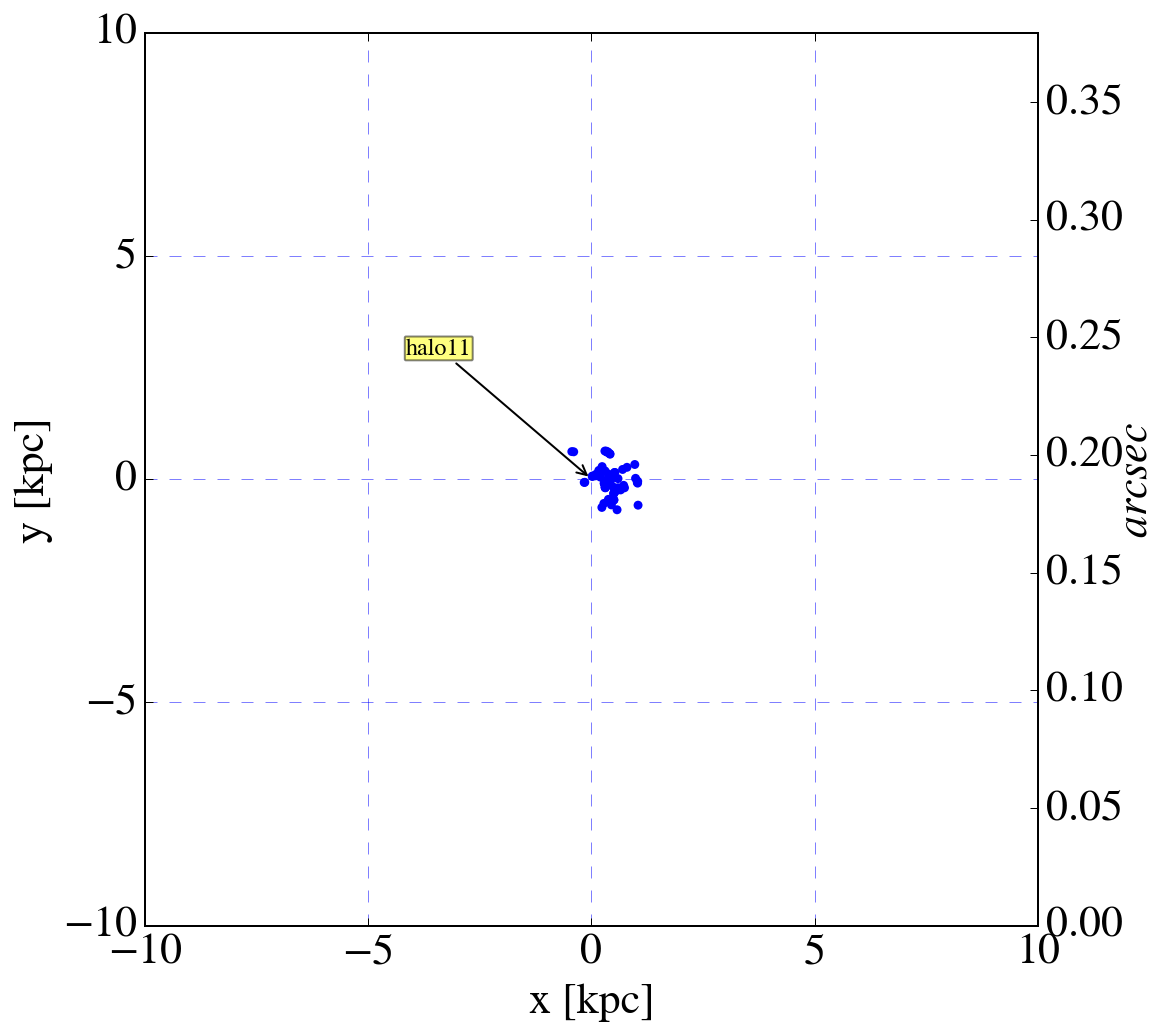

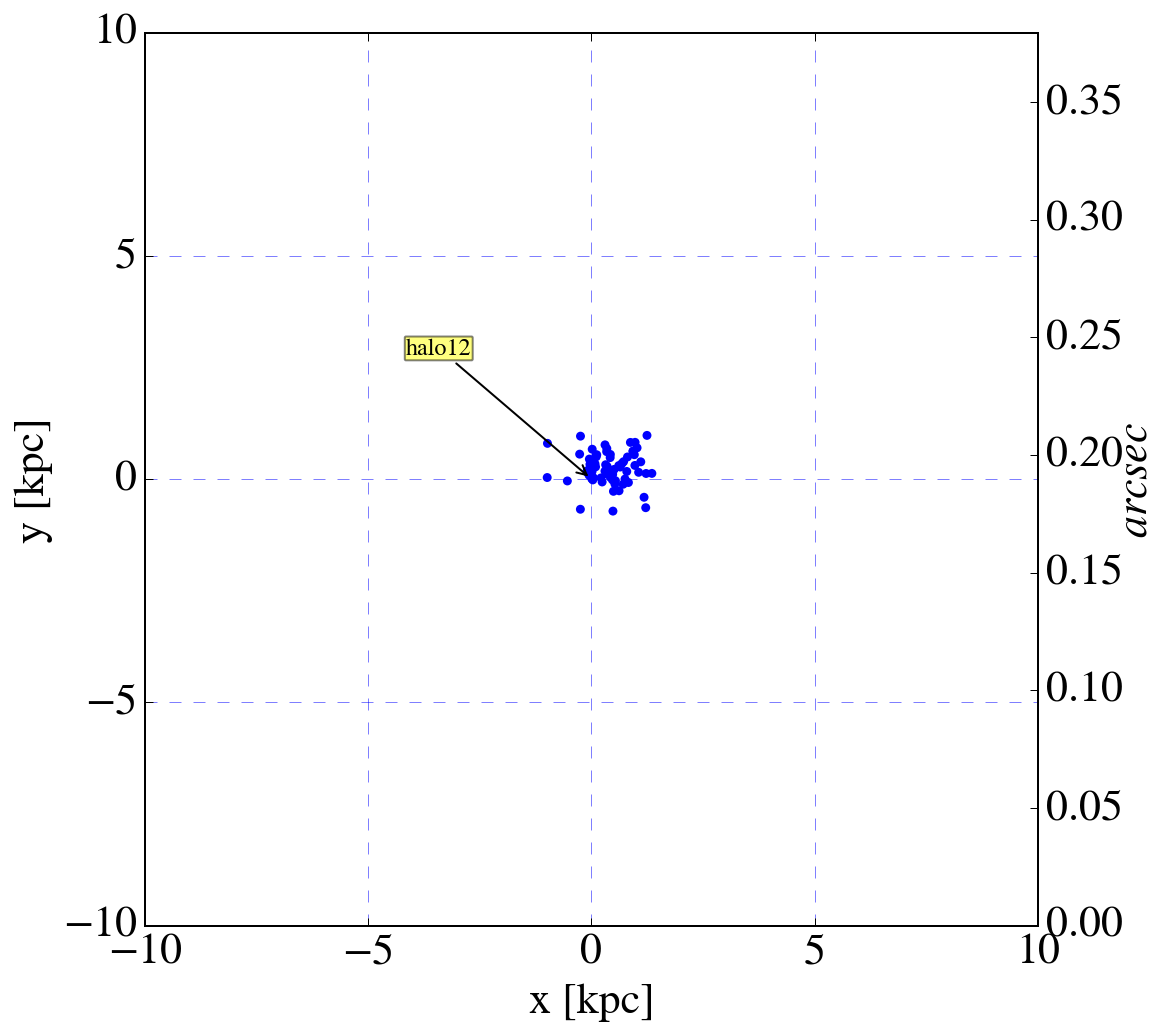

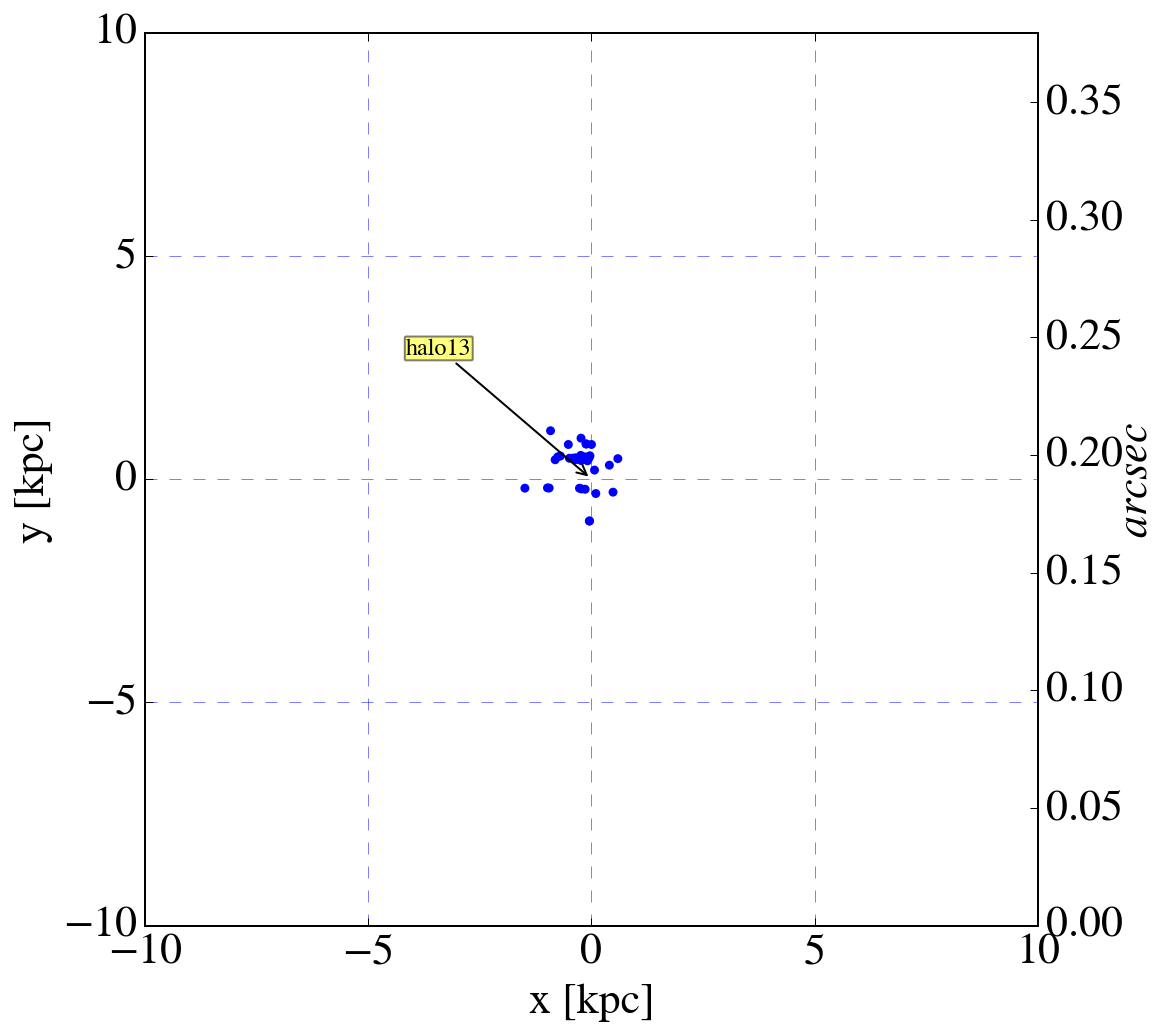

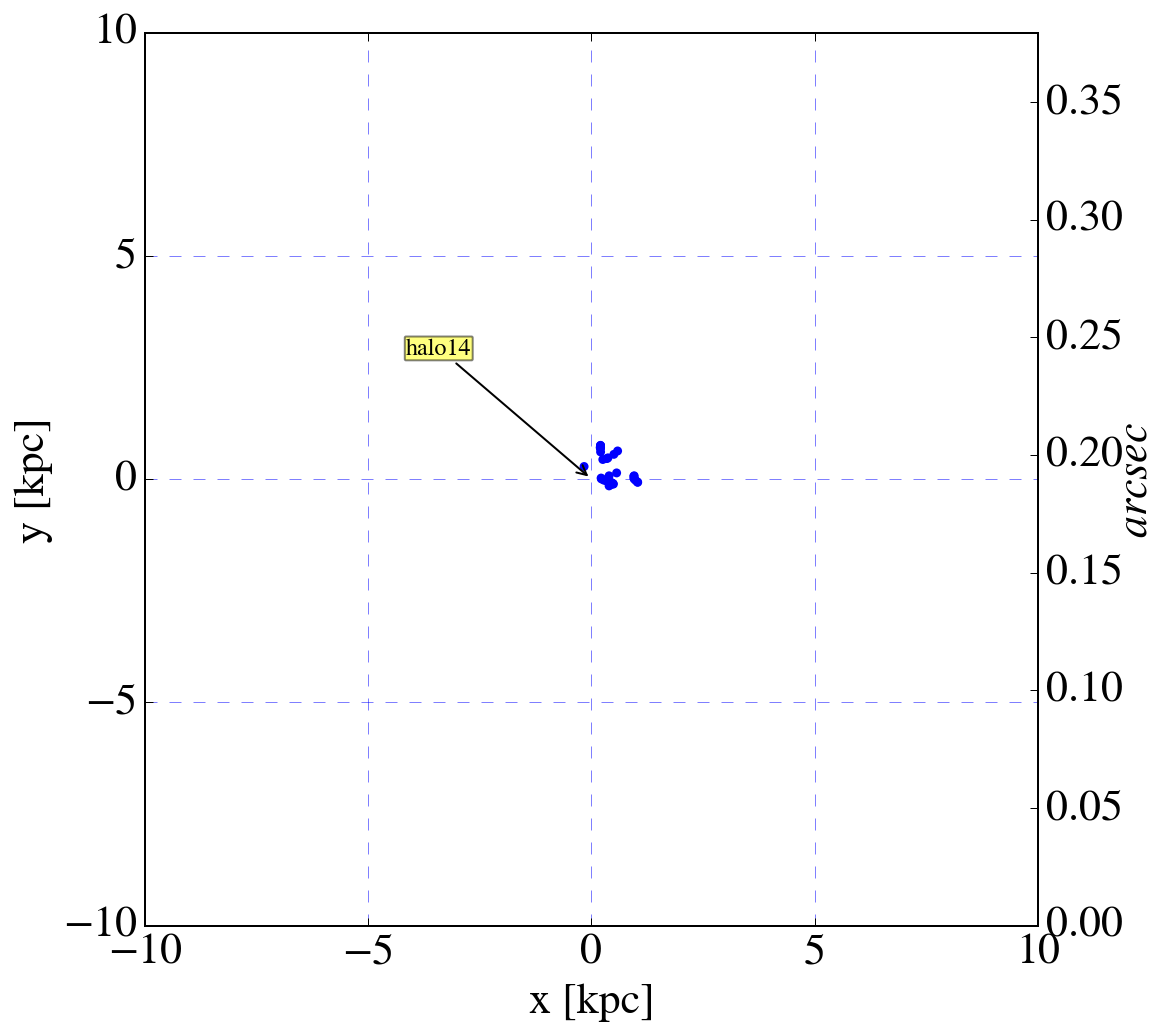

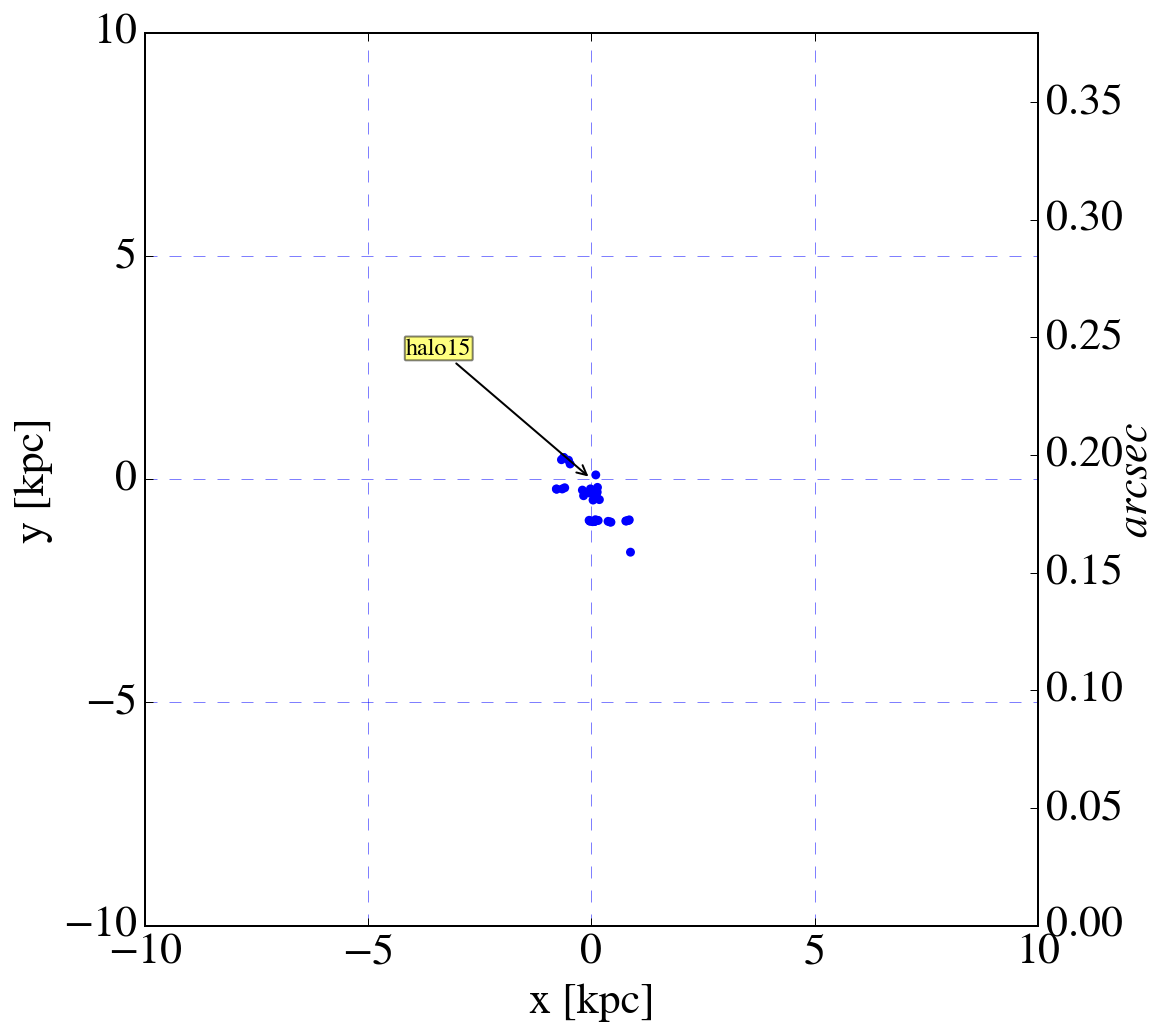

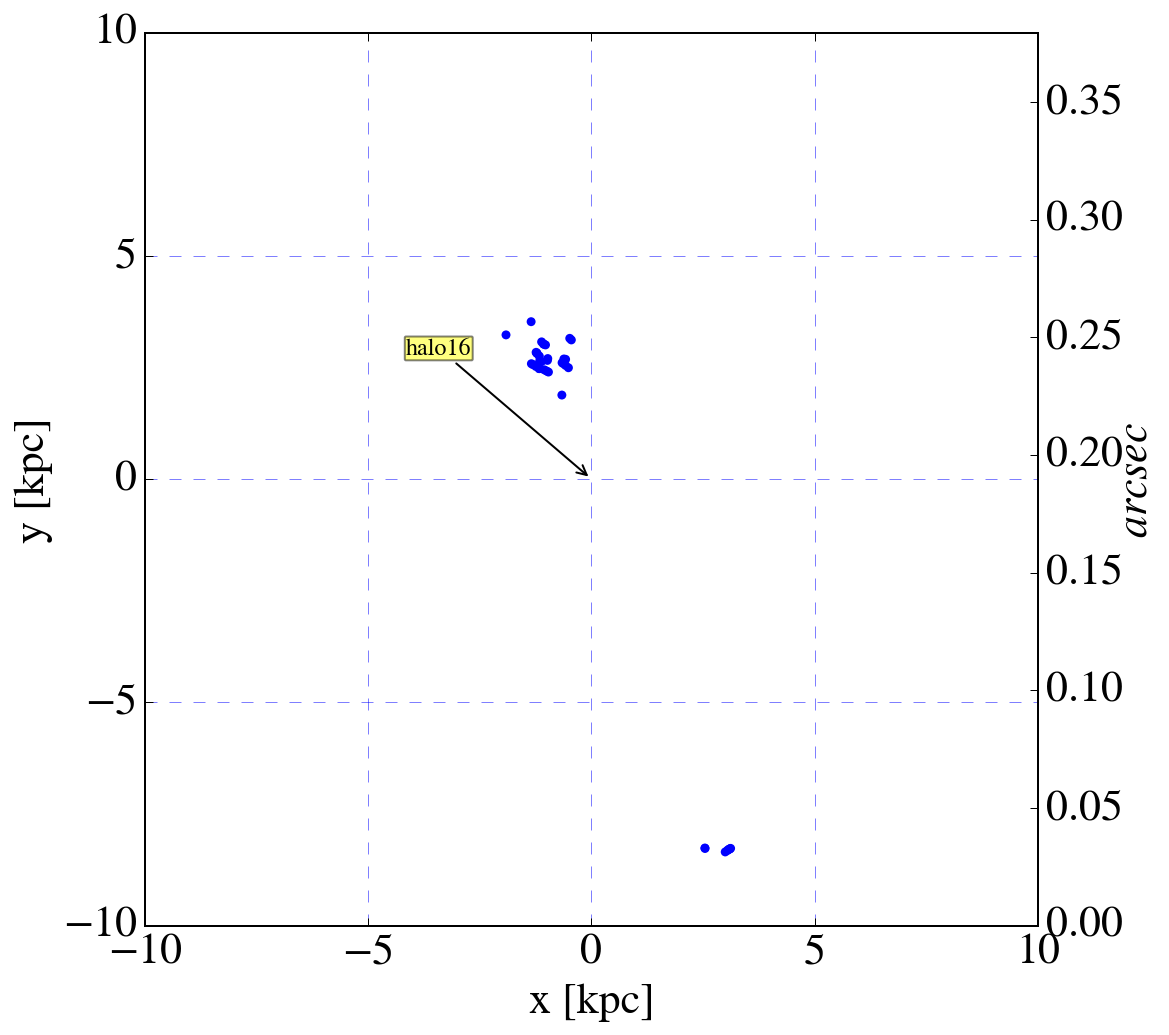

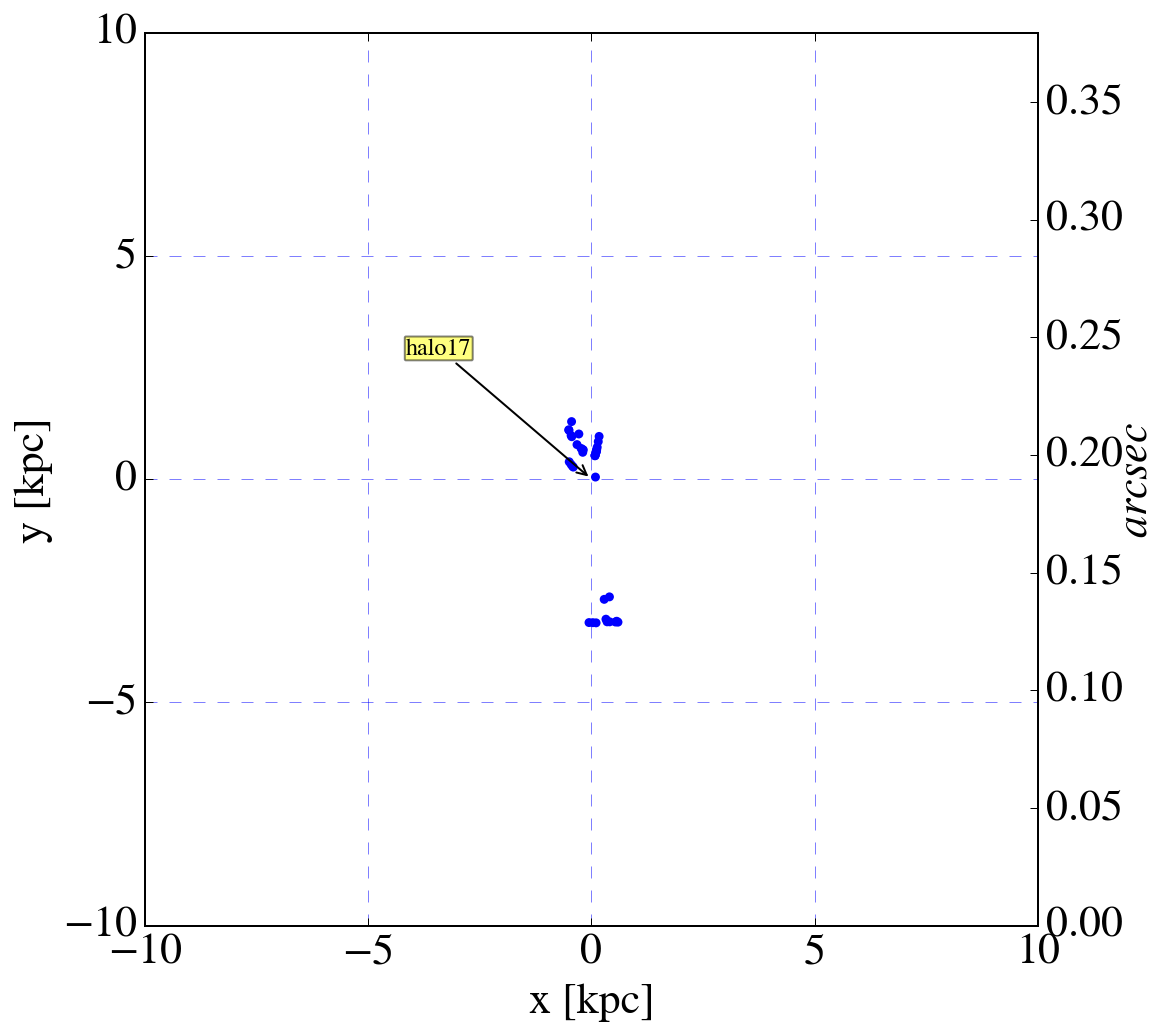

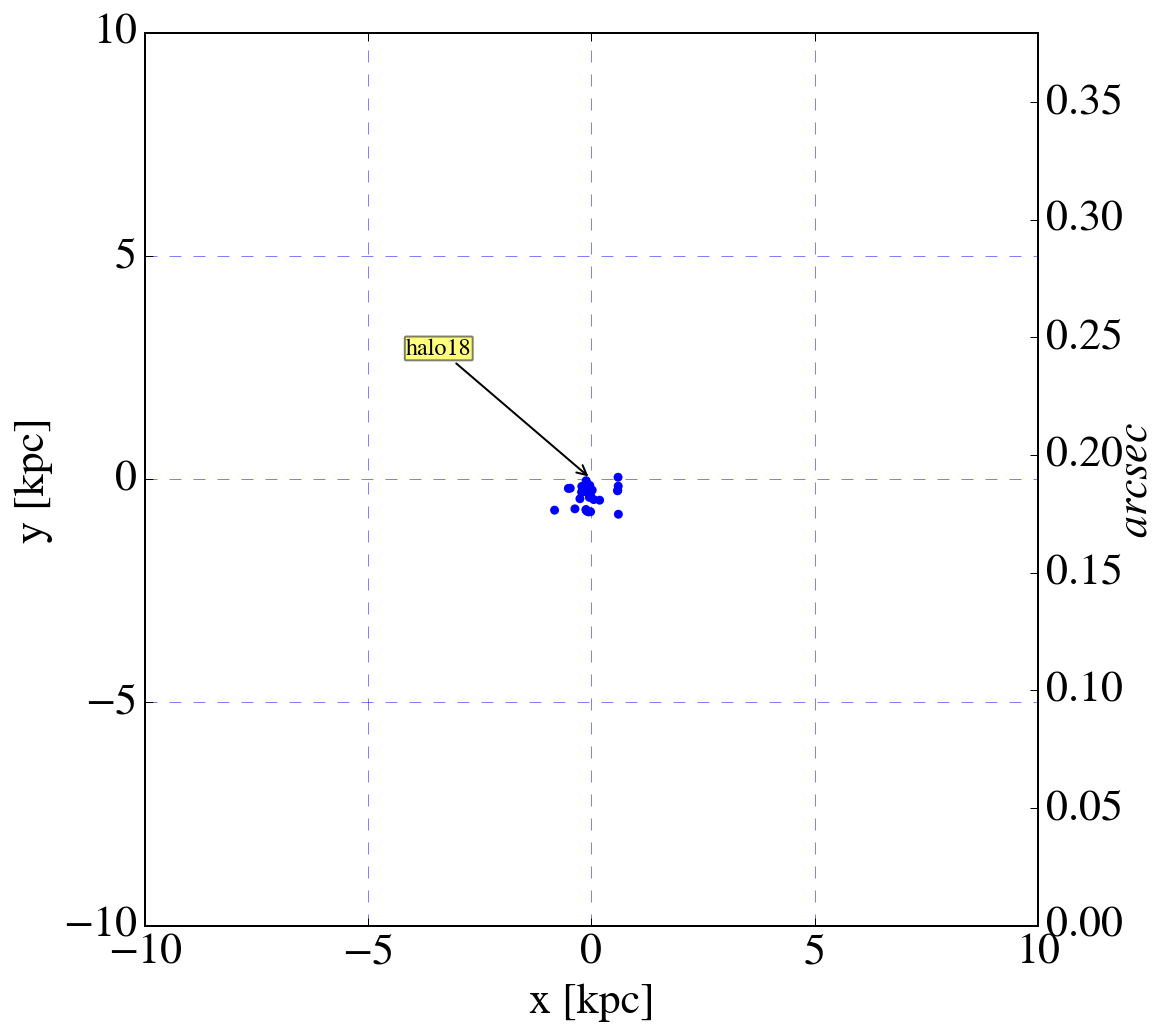

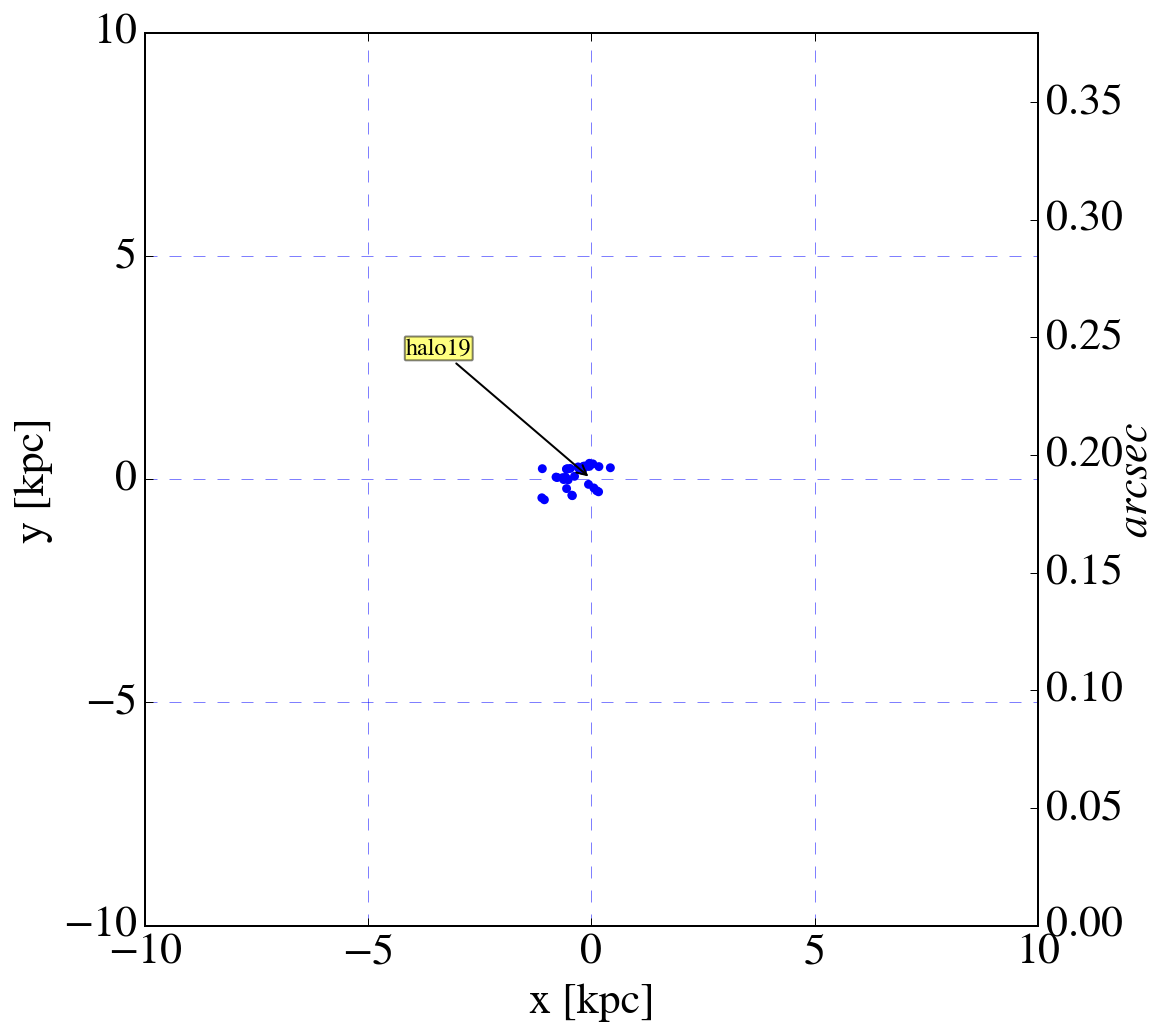

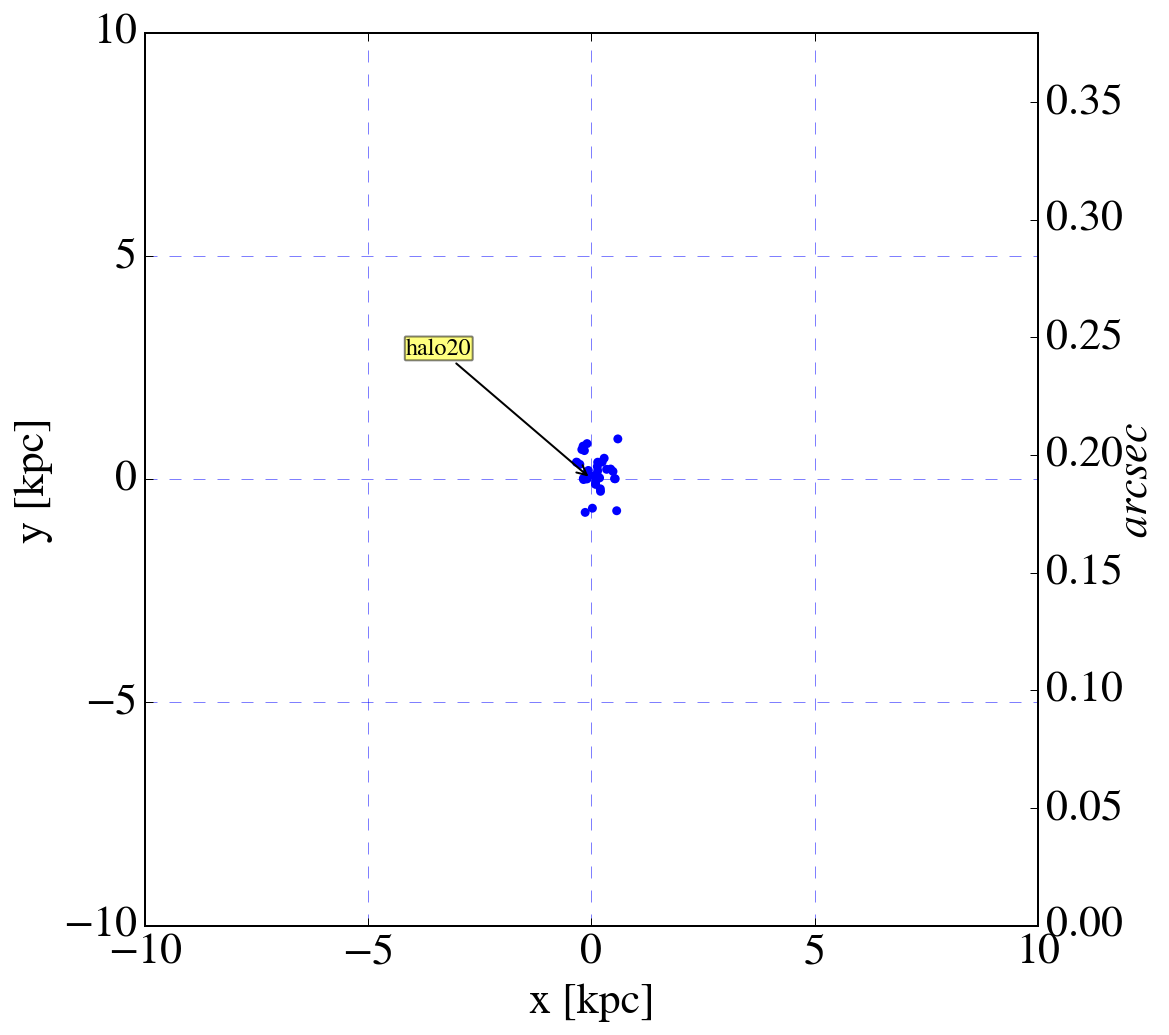

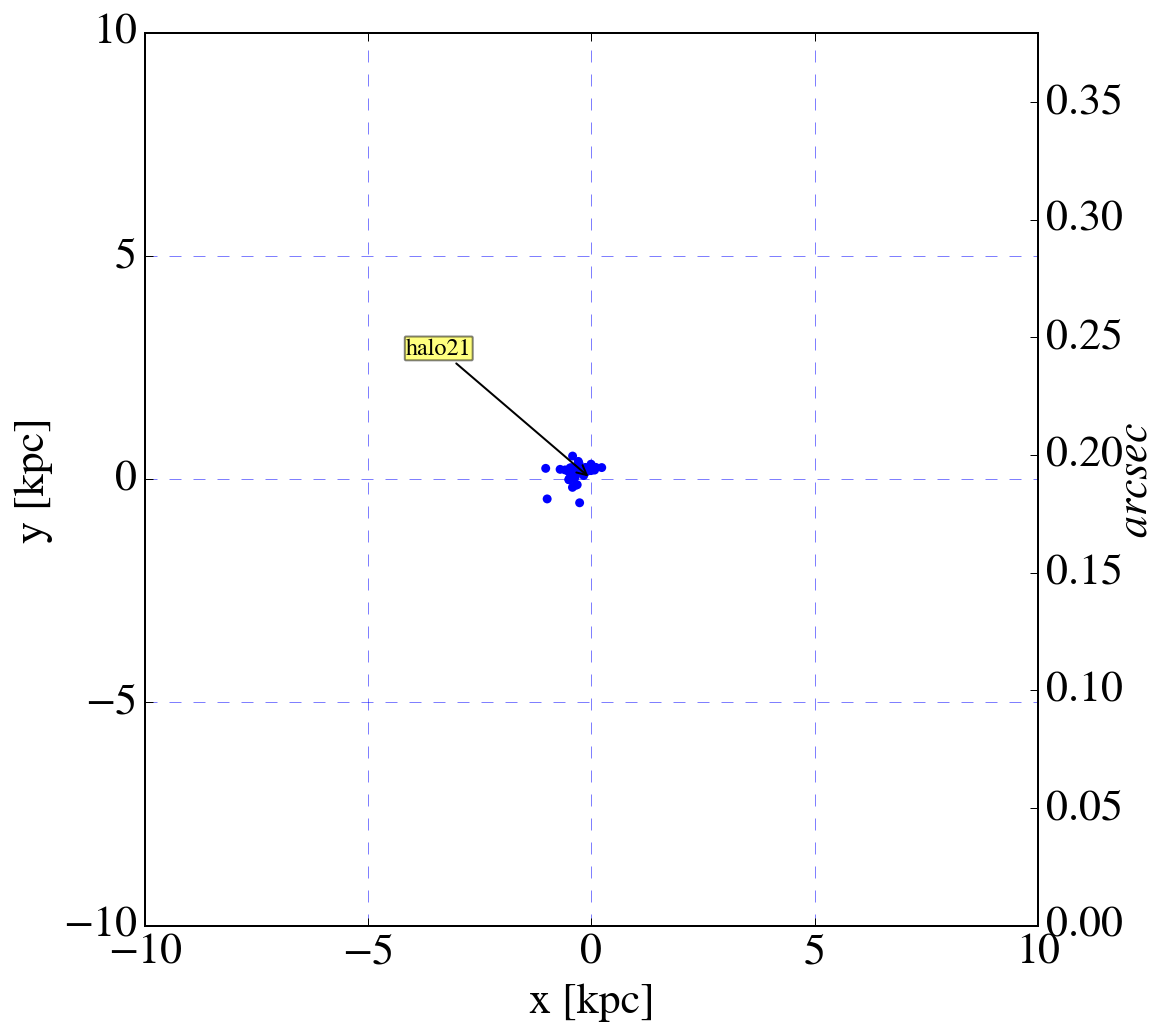

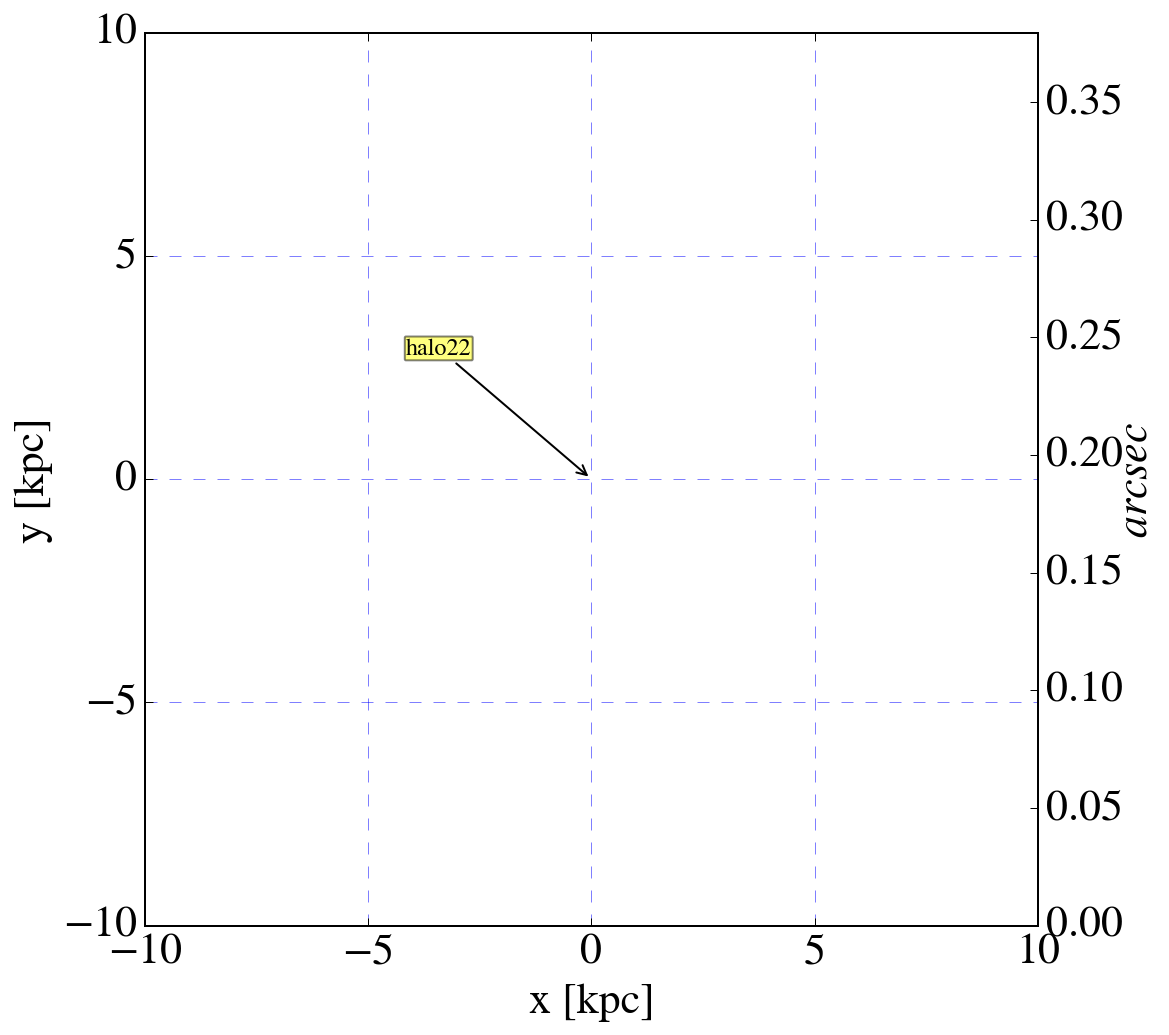

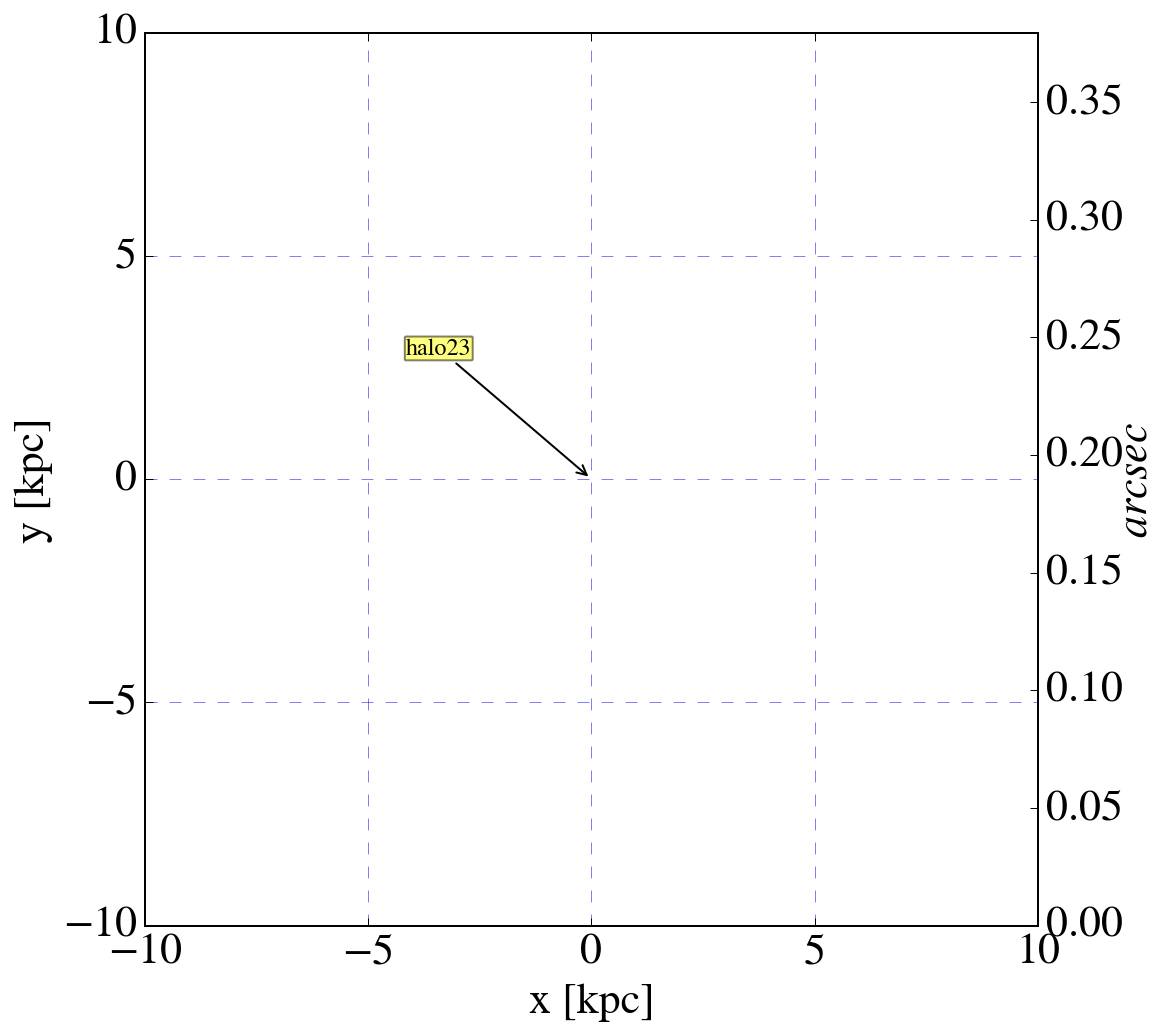

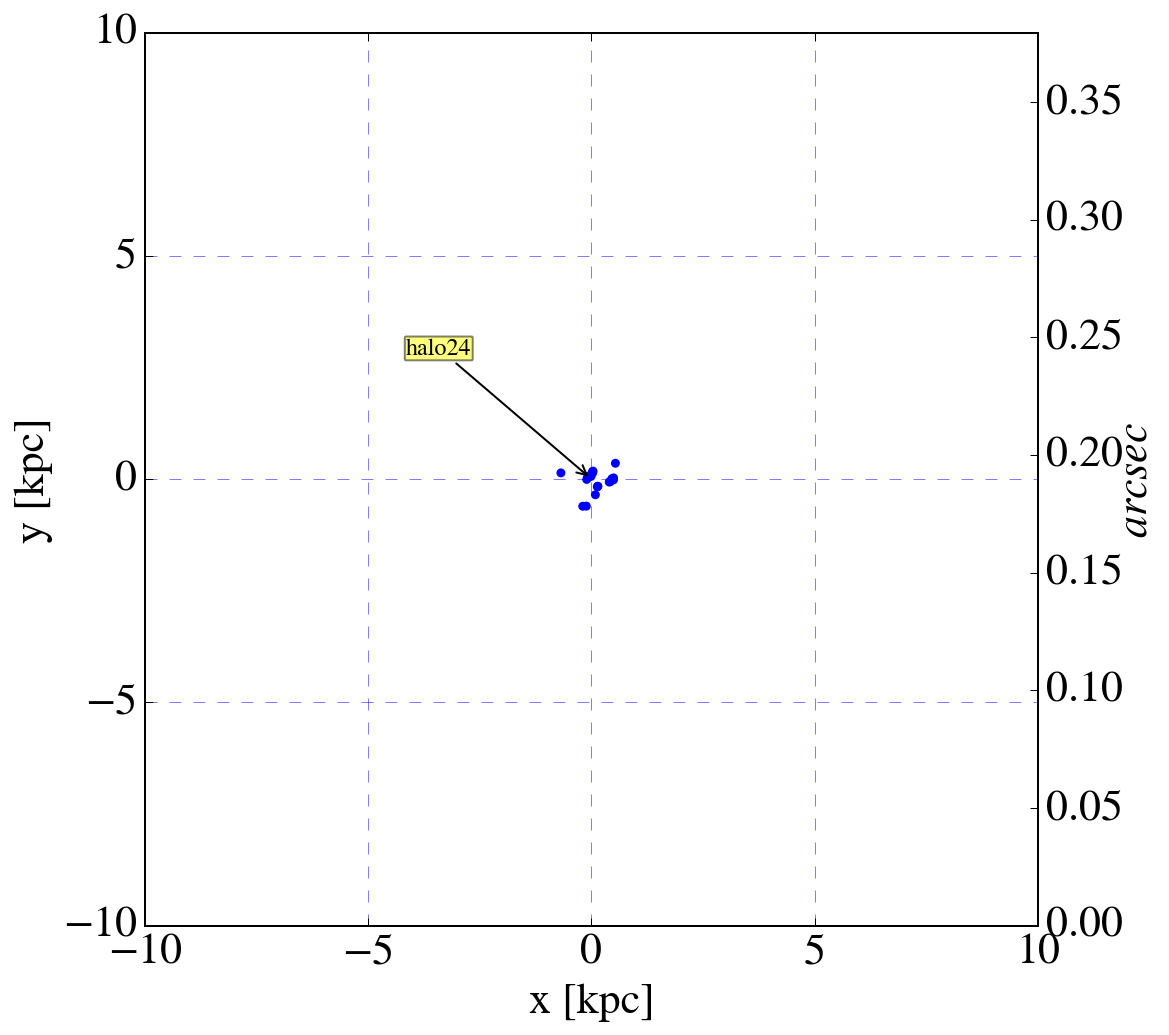

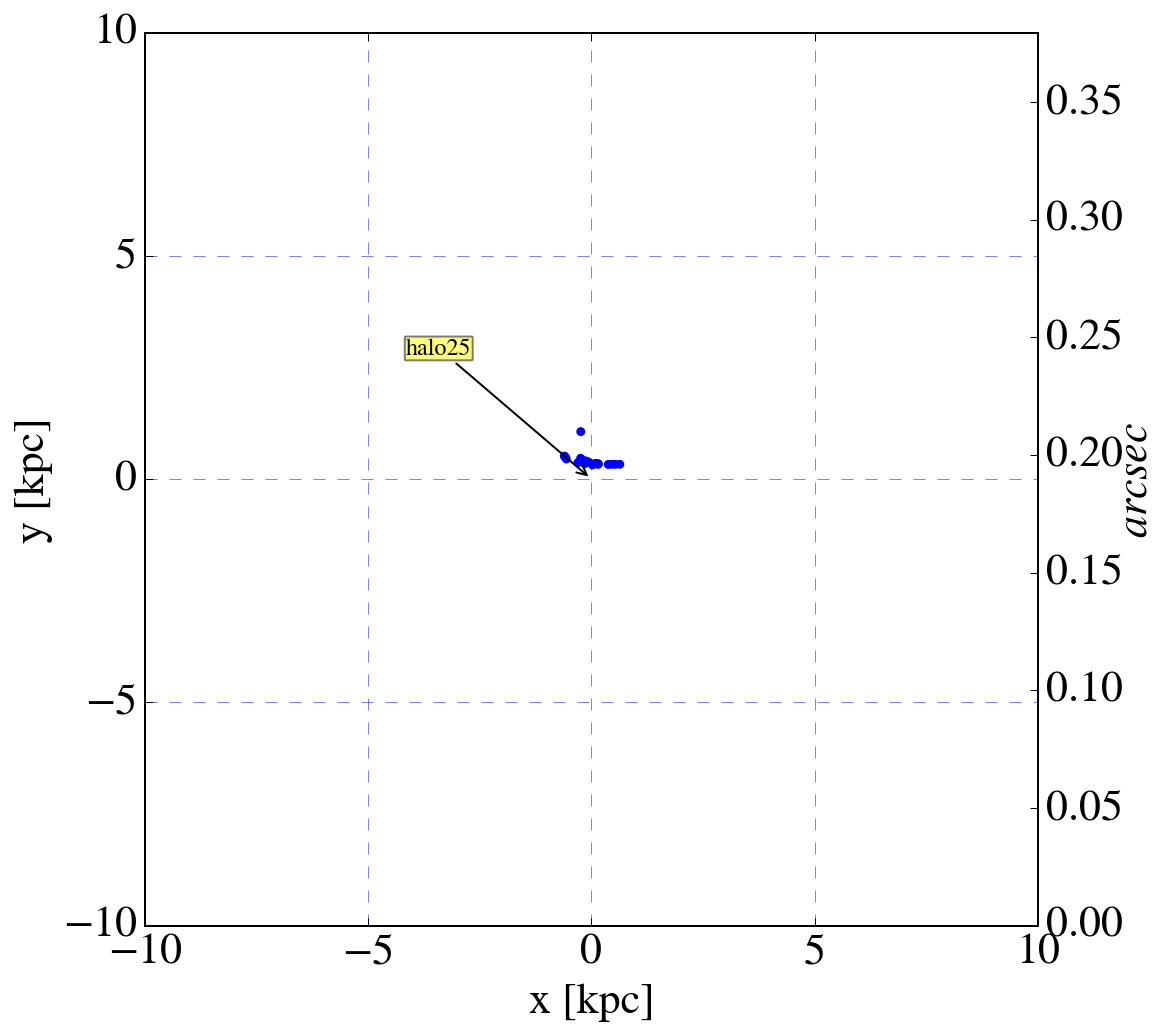

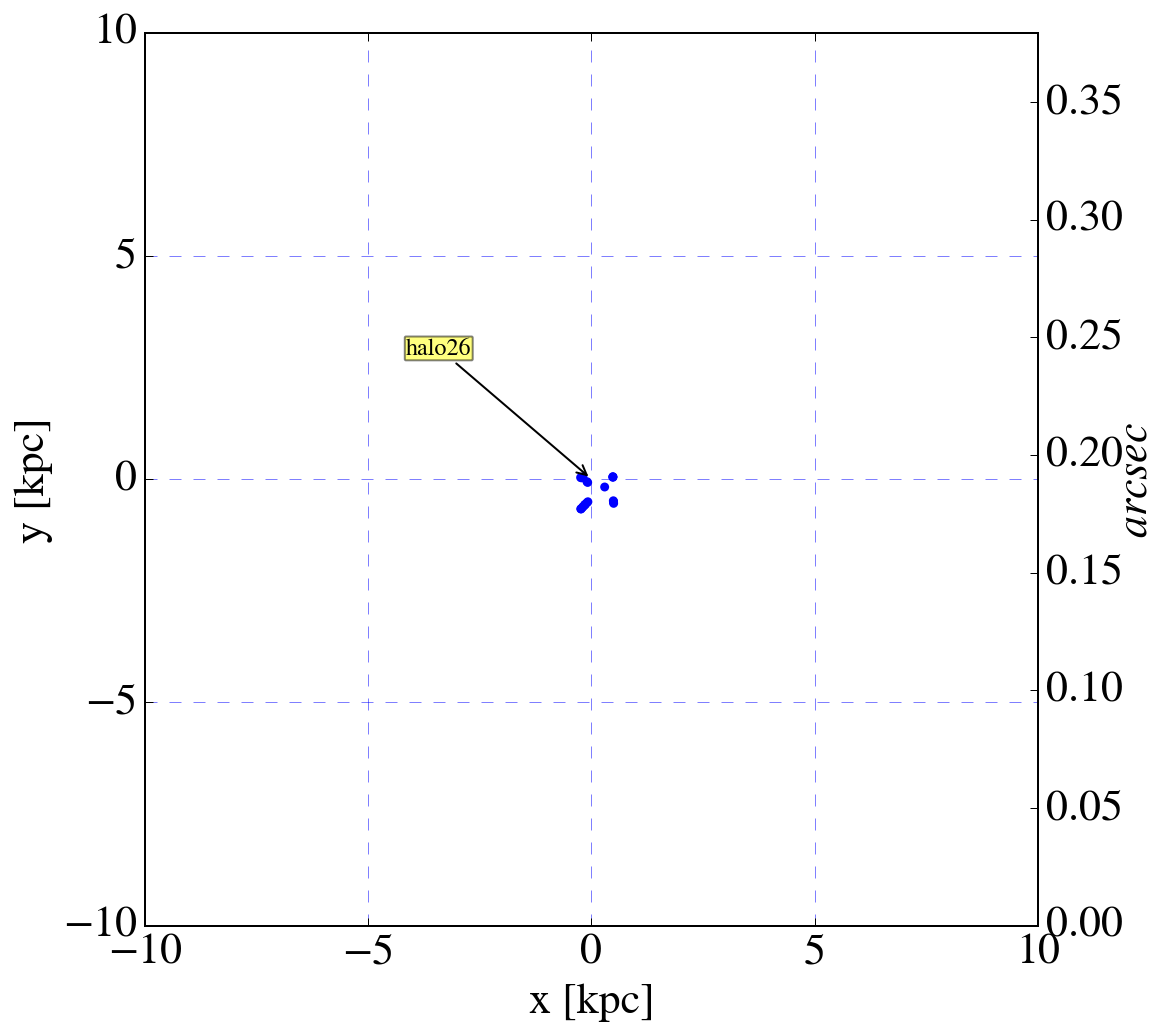

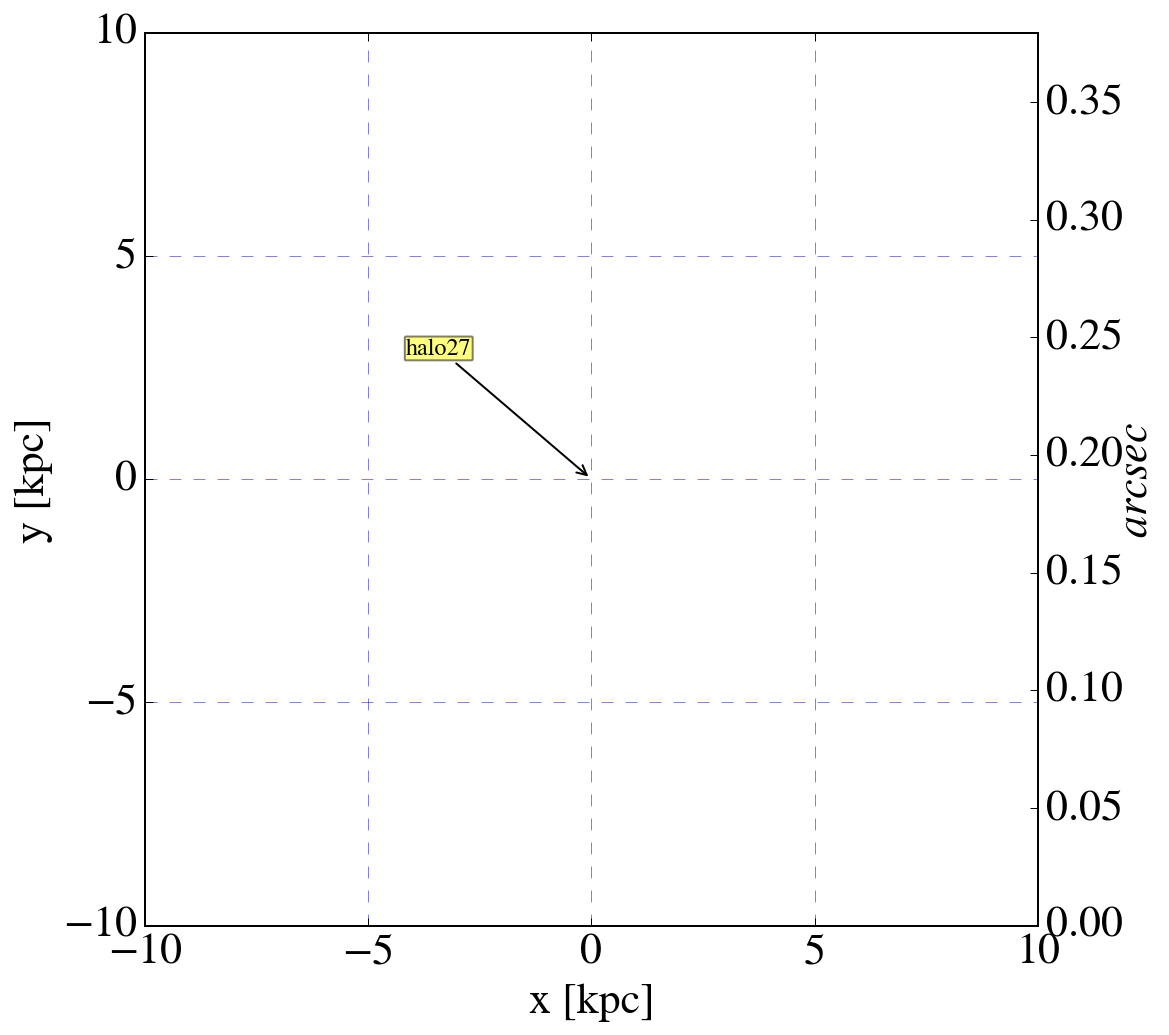

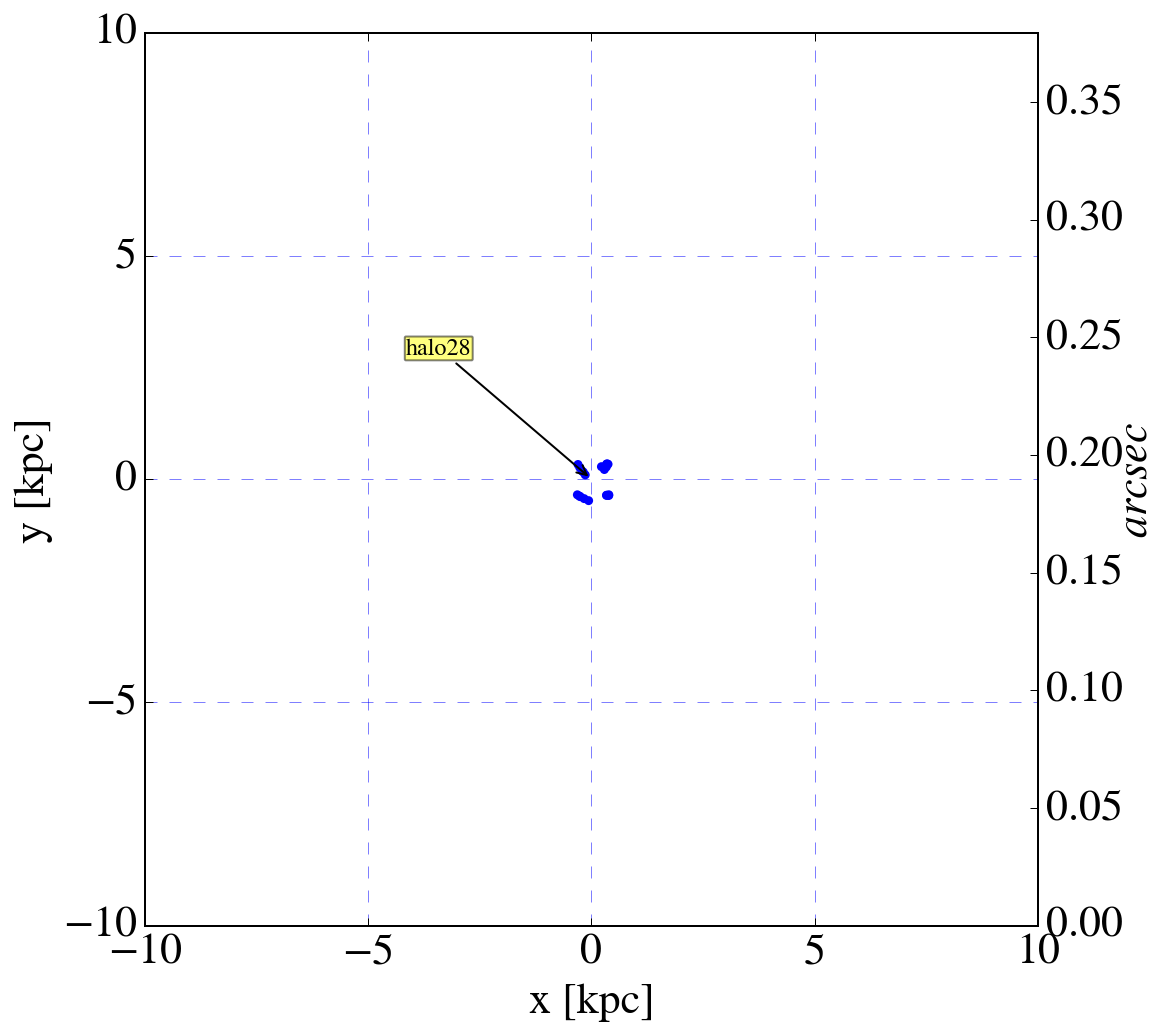

In [85]:
arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value 
print("arc sec/kpc = {:.3f}".format(arcSec_per_kpc_comov))
radius = 10.0
print('radius {:.2f}'.format(radius))
for halo in range(0,28):
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
#     radiusScaleFac = 0.5
#     radius = ((totMass(halossizes['count'][halo]) * 3.0/(4.0 * ma.pi) * \
#                1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * 100))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
#     radius = radius.value * radiusScaleFac

    # Pass locs and halosPos in kpc... 
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs * 1000.0,mass,spAges,Z,PZ,PPF,
                                                                          halosPos[halo] * 1000.0,radius)

    print("Halo mass {} is {:.2e}".format(halo, np.sum(halomass)))
    
    ax.scatter(haloStars[:,0],haloStars[:,1],s=20,facecolors='b', edgecolors='None') # Plot halo locs
    ax.annotate(
        'halo{0}'.format(halo+1), 
        xy = (0, 0), xytext = (-60, 60),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=12,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    ax.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_xlim([-radius,radius])
    ax.set_ylim([-radius,radius])
    hax2 = ax.twinx()
    hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
#     plt.savefig('/Users/earnric/Desktop/SP-galaxy_z_{}_{}.png'.format(z,halo),dpi=fig.dpi,bbox_inches='tight')
    del ax
gc.collect()

Halo mass 27 is 5.24e+04


7734

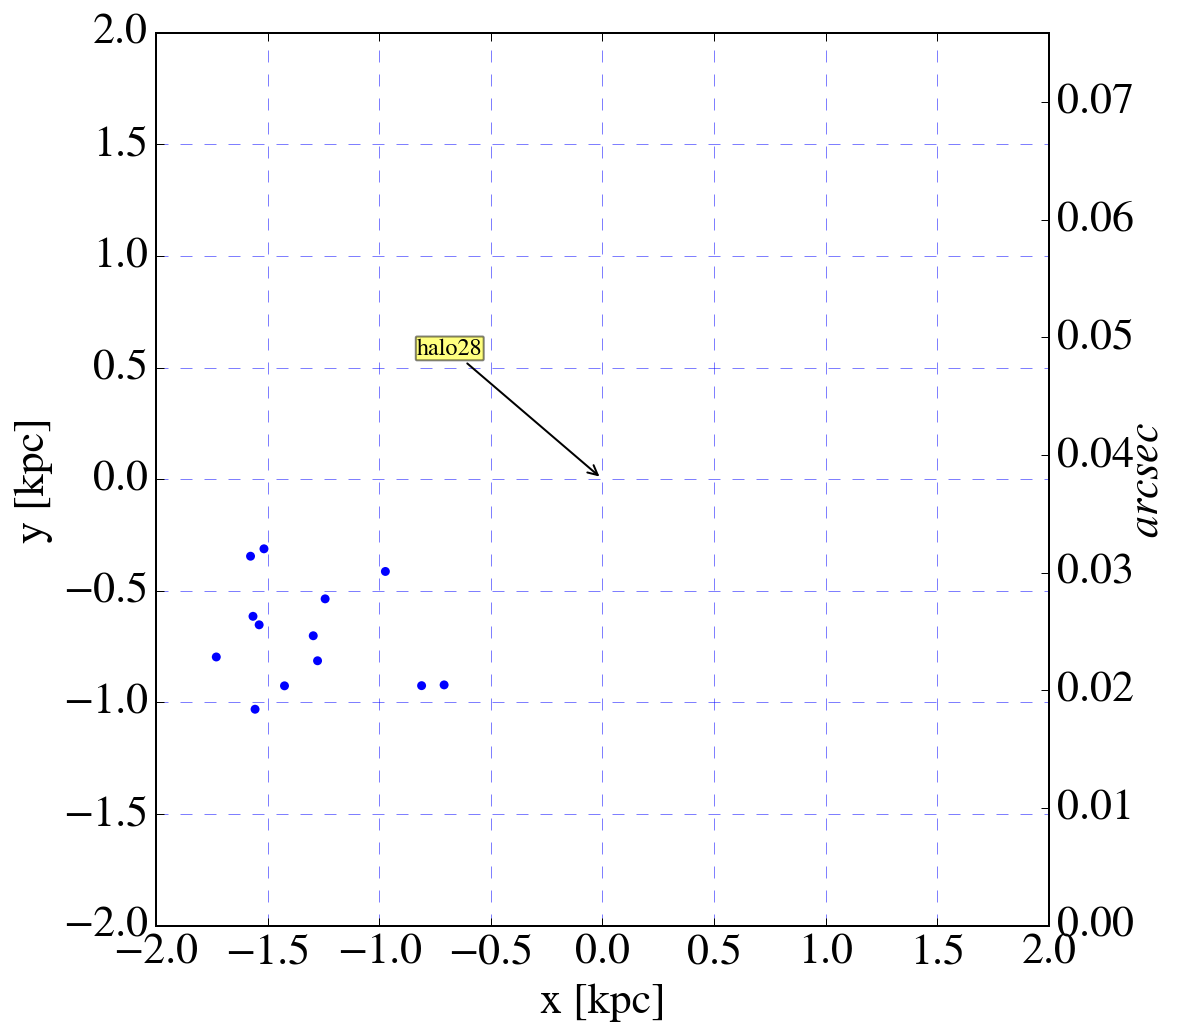

In [87]:
radius = 2.0
fig, ax = plt.subplots(1, 1, figsize=(8,8))
#     radiusScaleFac = 0.5
#     radius = ((totMass(halossizes['count'][halo]) * 3.0/(4.0 * ma.pi) * \
#                1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * 100))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
#     radius = radius.value * radiusScaleFac

# Pass locs and halosPos in kpc... 
haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs * 1000.0,mass,spAges,Z,PZ,PPF,
                                                                      halosPos[28] * 1000.0,radius)

print("Halo mass {} is {:.2e}".format(halo, np.sum(halomass)))

ax.scatter(haloStars[:,0],haloStars[:,1],s=20,facecolors='b', edgecolors='None') # Plot halo locs
ax.annotate(
    'halo{0}'.format(halo+1), 
    xy = (0, 0), xytext = (-60, 60),
    textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=12,
    bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_xlim([-radius,radius])
ax.set_ylim([-radius,radius])
hax2 = ax.twinx()
hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
hax2.set_ylabel(r'$arcsec$')
hax2.yaxis.labelpad = -3
#     plt.savefig('/Users/earnric/Desktop/SP-galaxy_z_{}_{}.png'.format(z,halo),dpi=fig.dpi,bbox_inches='tight')
del ax
gc.collect()

In [89]:
haloZ,halomass

(array([  5.00000000e-09,   5.00000000e-09,   5.00000000e-09,
          8.48581369e-04,   6.02396904e-04,   6.44349668e-04,
          1.08430022e-03,   7.25859212e-04,   1.28296949e-03,
          1.26585531e-03,   7.90254165e-04,   1.21588088e-03,
          1.44364475e-03]),
 array([ 3715.02775373,  3715.02775373,  3715.02775373,  4127.80861526,
         4127.80861526,  4127.80861526,  4127.80861526,  4127.80861526,
         4127.80861526,  4127.80861526,  4127.80861526,  4127.80861526,
         4127.80861526]))

In [70]:
halosPos[6]

array([ 1.572 , -1.884 ,  0.6384])

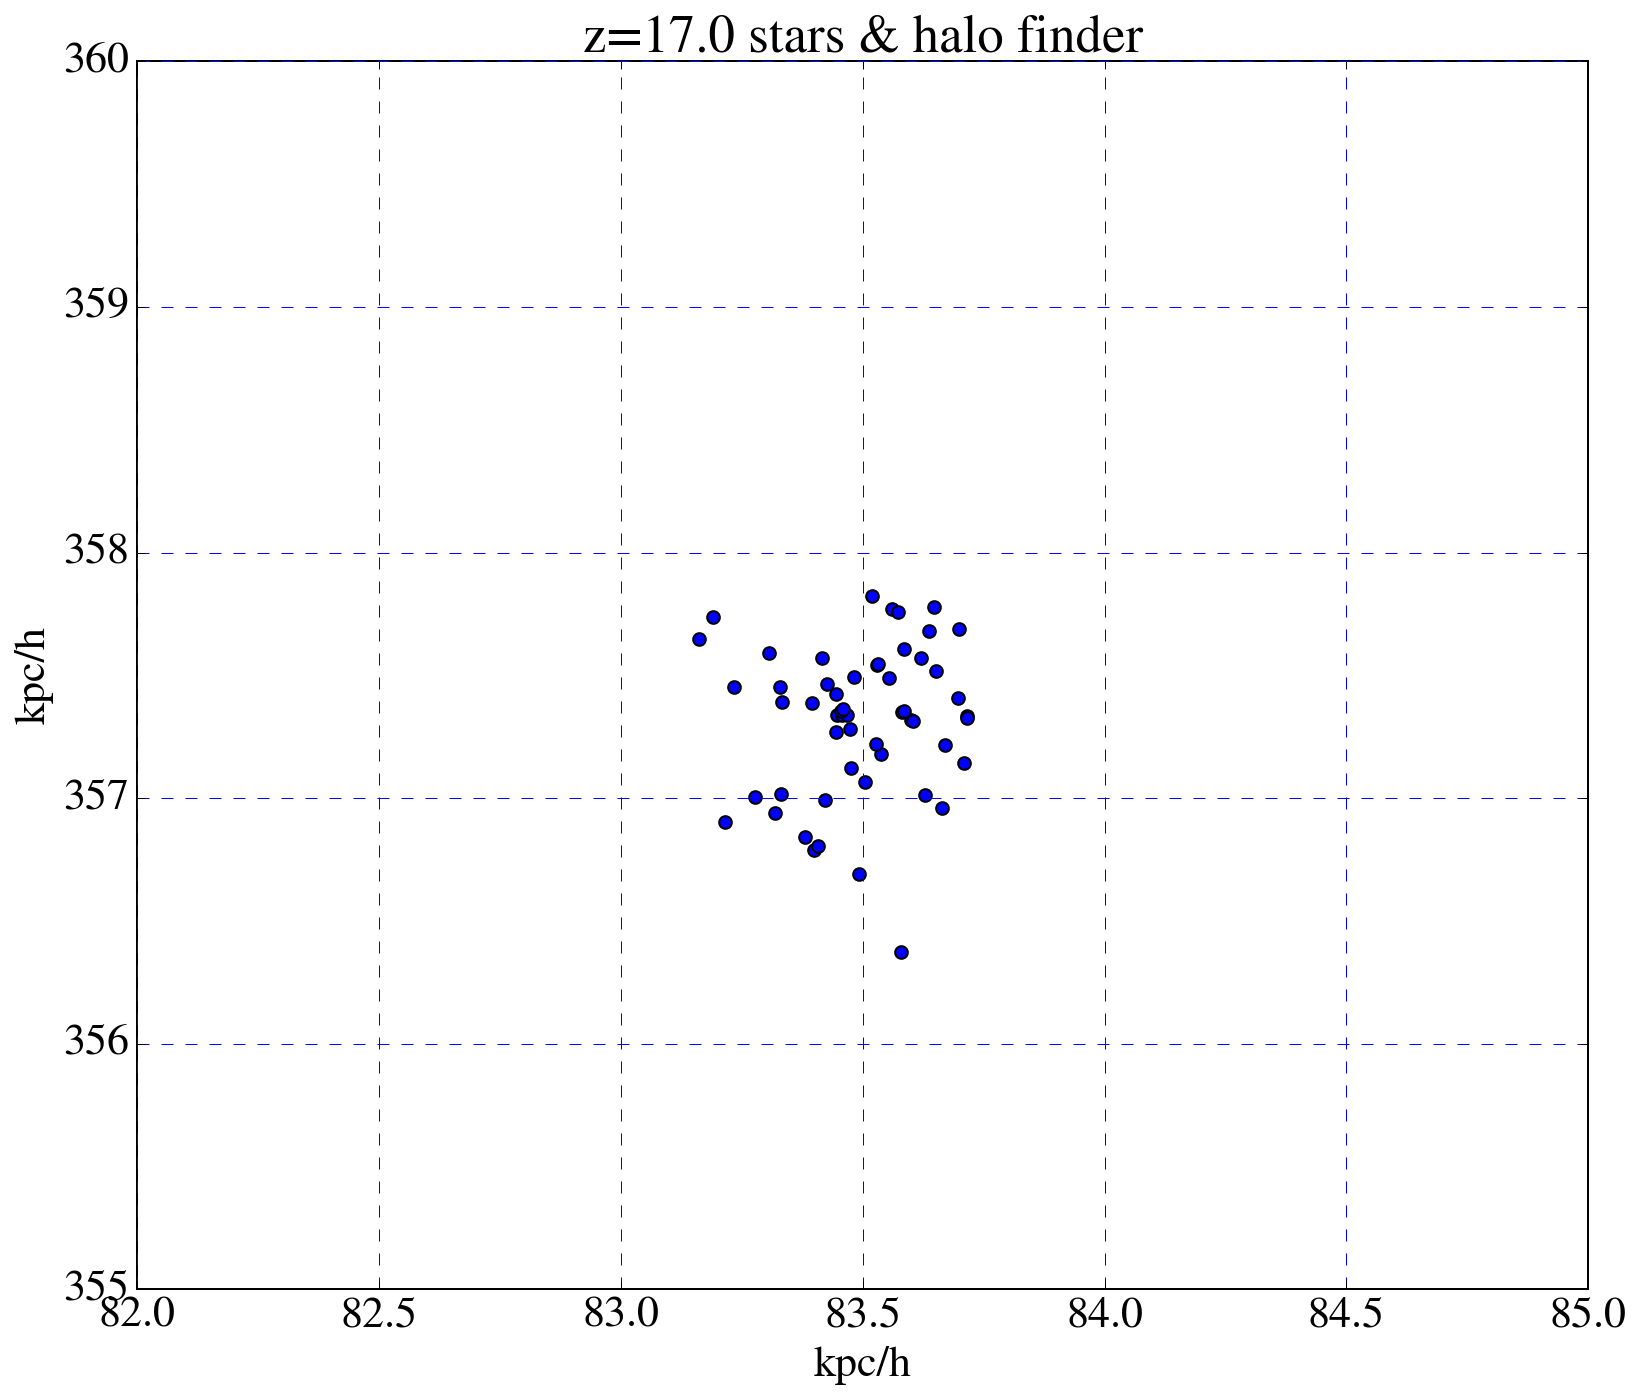

4018

In [28]:
htp = len(halosRawPos)
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,0]*1000,locs[:,1]*1000,s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0]*1000,halosPos[:htp,1]*1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('kpc/h')
plt.ylabel('kpc/h')
plt.xlim([82.0,85.0])
plt.ylim([355.0,360.0])

plt.title('z=%.1lf stars & halo finder'%z)

plt.show()
gc.collect()
 

In [32]:
viewhaloStars,viewhalomass,viewhaloages,viewhaloZ,viewhaloPZ,viewhaloPPF = halos.getViewStars(locs * 1000.0,mass,spAges,
                                                                                        Z,PZ,PPF,[83.5,357.0,0.0])

In [35]:
viewhaloStars[0]

array([ -5.49745236e-02,   2.67943263e-01,   3.51693762e+03])

Halo mass 4 is 2.20e+05


12458

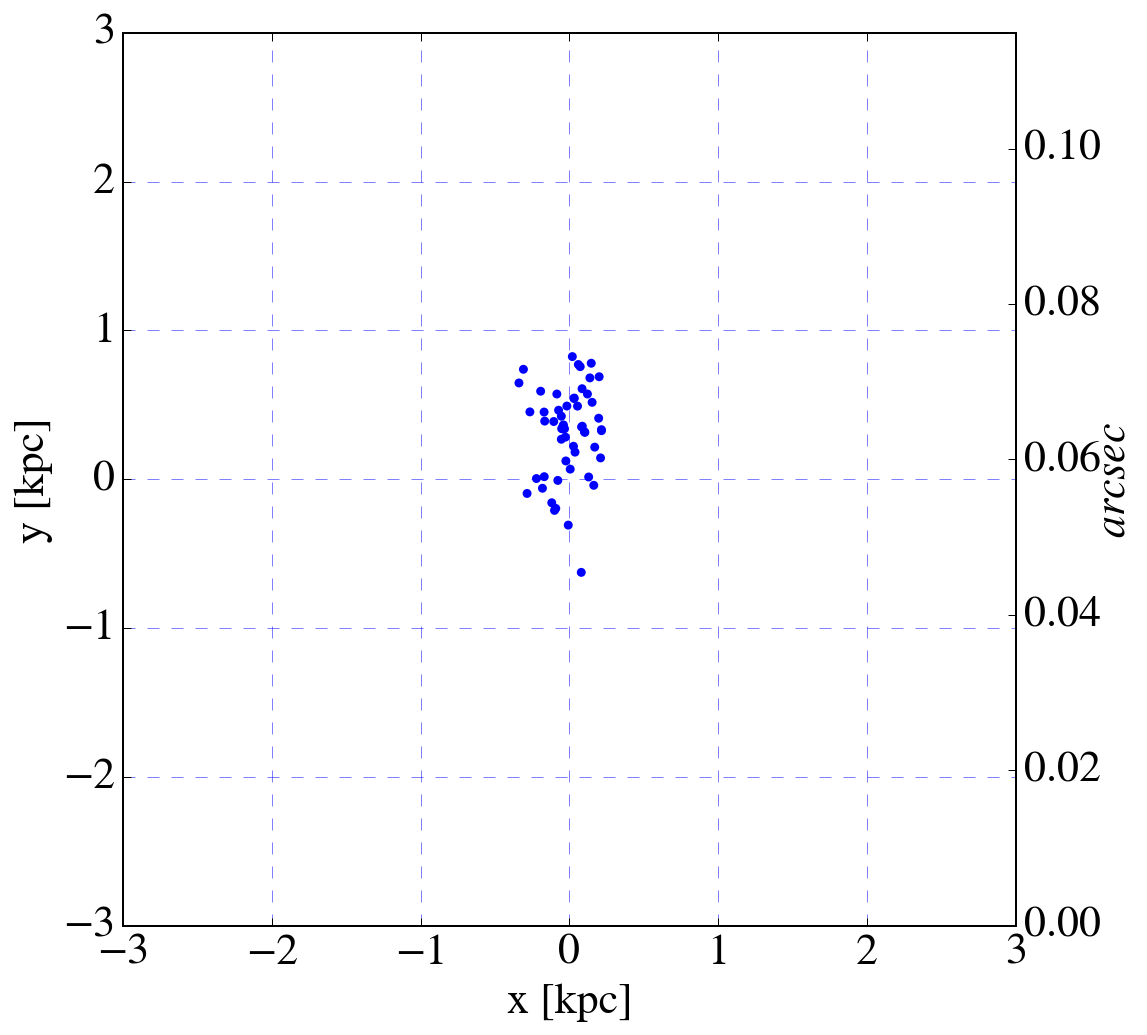

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
# Pass locs and halosPos in kpc... 
radius = 3.0
haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs * 1000.0,mass,spAges,Z,PZ,PPF,
                                                                      [83.5,357.0,3517],radius)

print("Halo mass {} is {:.2e}".format(halo, np.sum(halomass)))

ax.scatter(haloStars[:,0],haloStars[:,1],s=20,facecolors='b', edgecolors='None') # Plot halo locs

ax.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_xlim([-radius,radius])
ax.set_ylim([-radius,radius])
hax2 = ax.twinx()
hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
hax2.set_ylabel(r'$arcsec$')
hax2.yaxis.labelpad = -3
del ax
gc.collect()

Examine not-found halo for z = 18 data

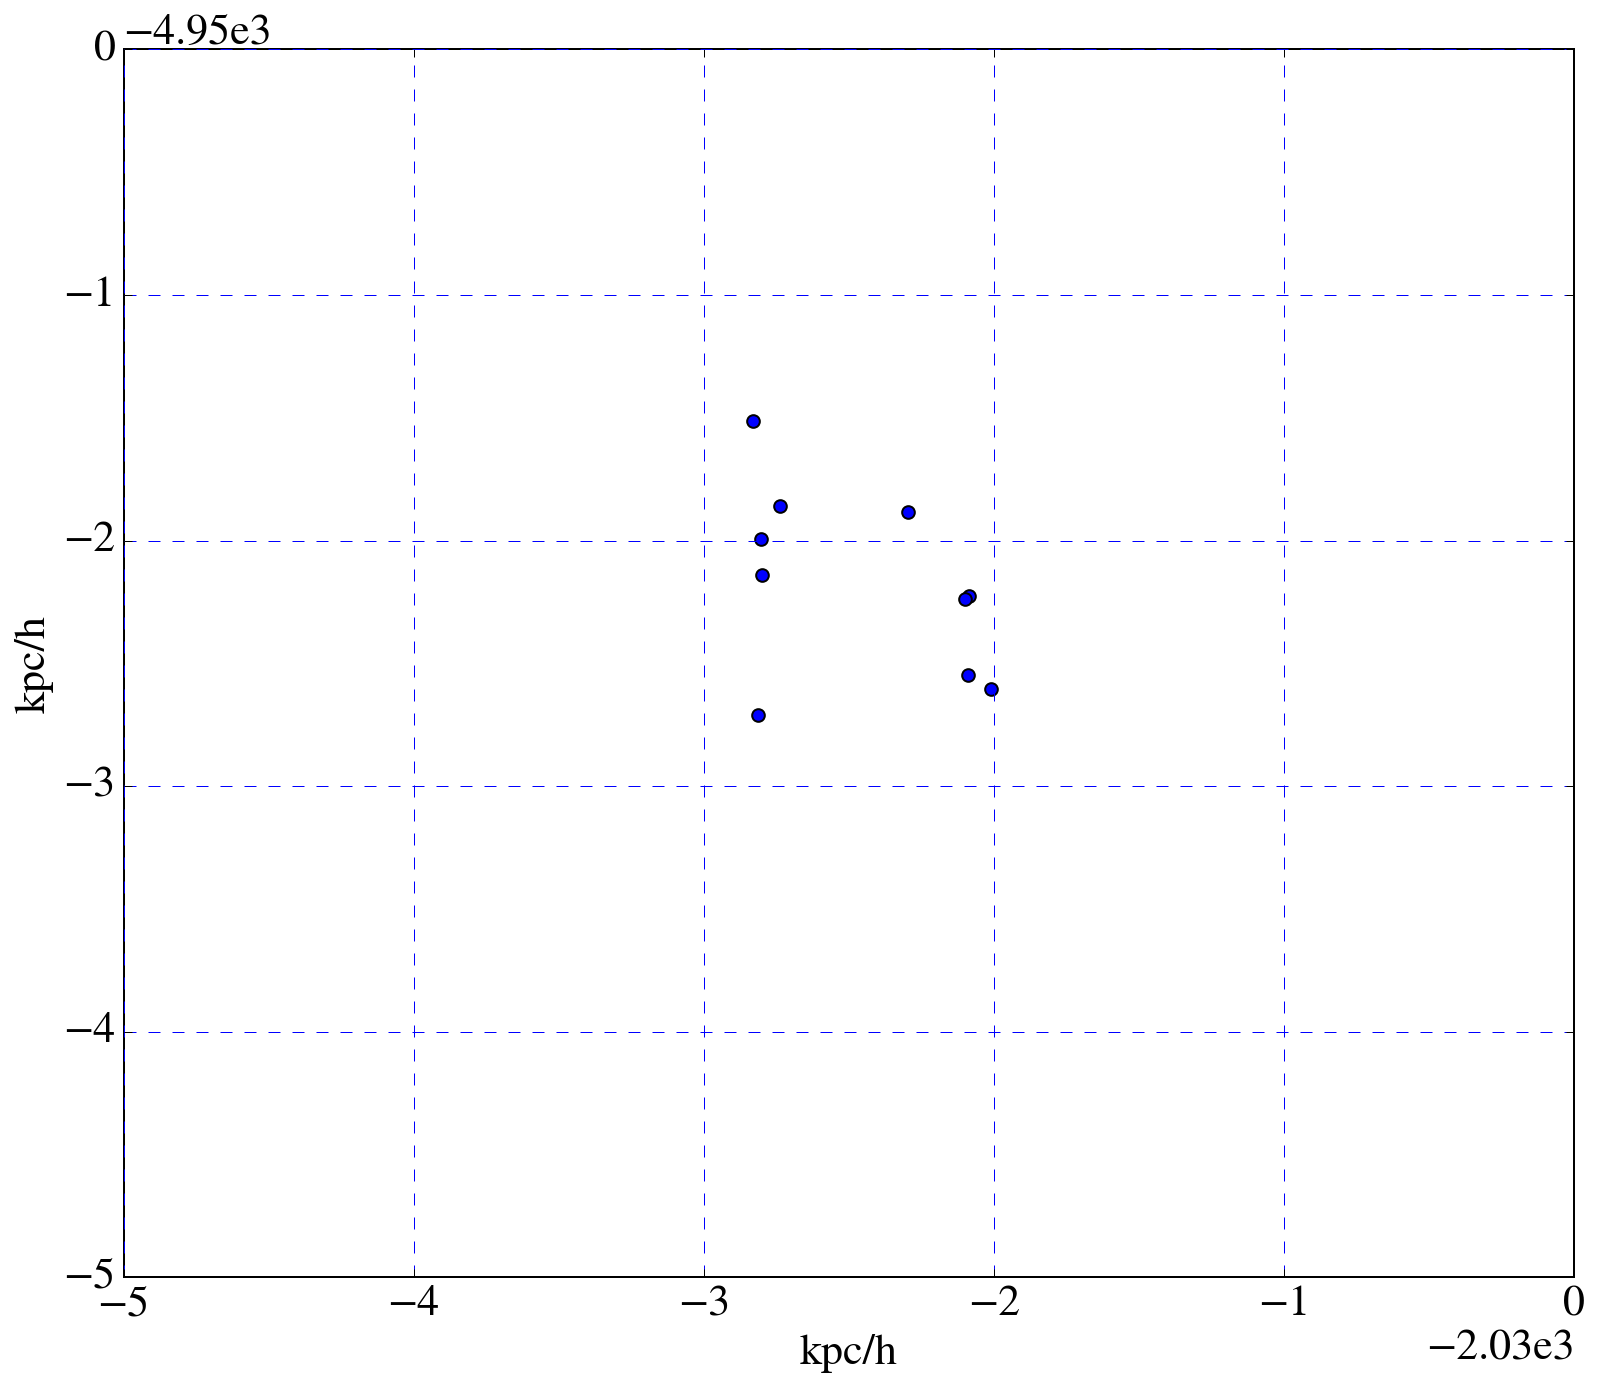

3925

In [93]:
# z = 18
plt.scatter(locs[:,0]*1000,locs[:,1]*1000,s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0]*1000,halosPos[:htp,1]*1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('kpc/h')
plt.ylabel('kpc/h')
plt.xlim([-2035.0,-2030.0])
plt.ylim([-4955.0,-4950.0])

plt.show()
gc.collect()
 

In [94]:
viewhaloStars,viewhalomass,viewhaloages,viewhaloZ,viewhaloPZ,viewhaloPPF = halos.getViewStars(locs * 1000.0,mass,spAges,
                                                                                        Z,PZ,PPF,[-2033.5,-4952.5,0.0])

In [95]:
viewhaloStars

array([[  1.20288439e+00,   6.15225821e-01,   2.80807944e+02],
       [  7.61001102e-01,   6.40498444e-01,   2.81438049e+02],
       [  1.41105060e+00,  -4.70056831e-02,   2.81843277e+02],
       [  1.48867484e+00,  -1.03630491e-01,   2.81215261e+02],
       [  6.96494403e-01,   5.04384828e-01,   2.81786165e+02],
       [  6.85639657e-01,  -2.09595240e-01,   2.82001980e+02],
       [  7.01588843e-01,   3.57676540e-01,   2.81411285e+02],
       [  1.41484363e+00,   2.74159260e-01,   2.80828541e+02],
       [  1.40084861e+00,   2.63707810e-01,   2.81571263e+02],
       [  6.69584383e-01,   9.84999115e-01,   2.81573732e+02]])

Halo mass 27 is 4.09e+04


8168

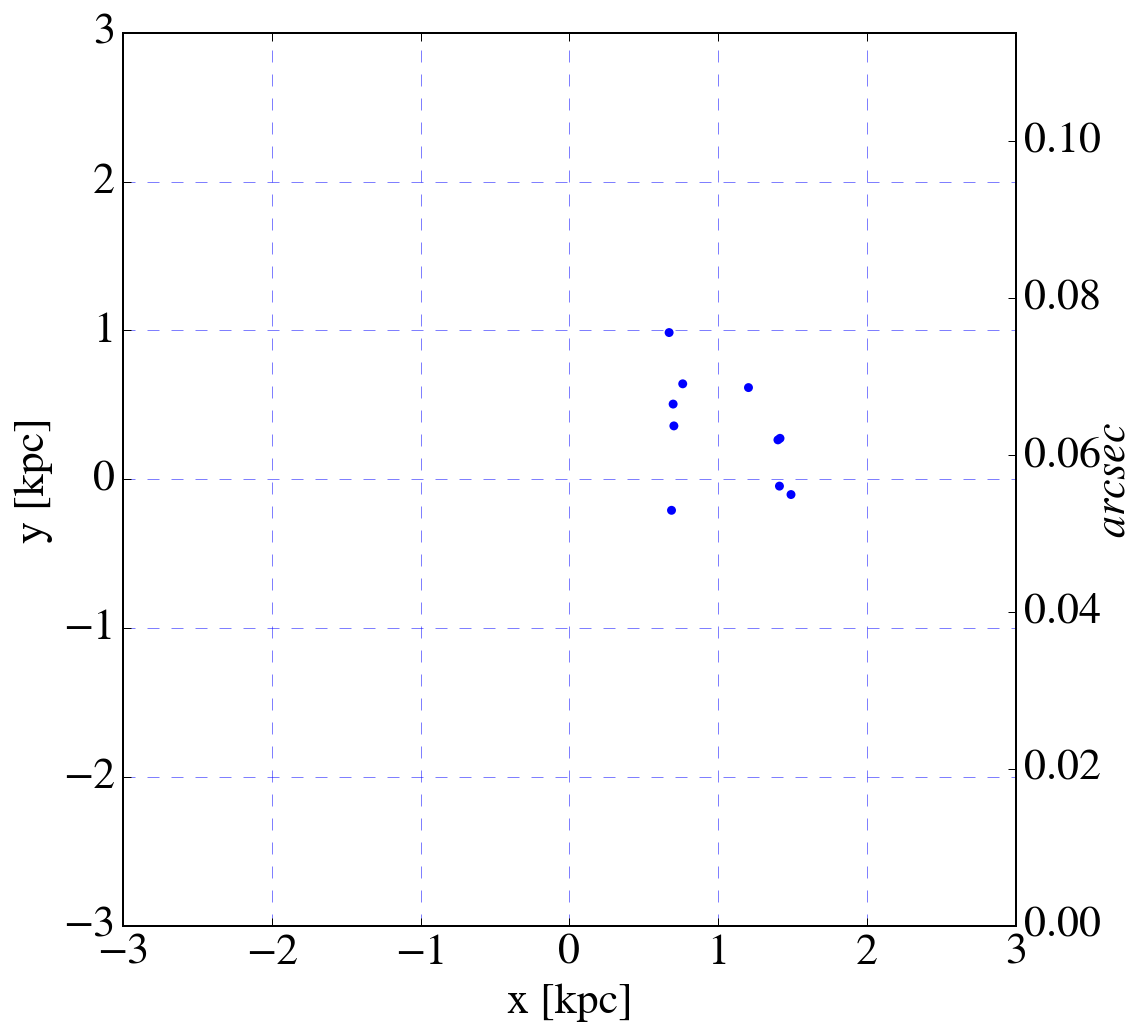

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
# Pass locs and halosPos in kpc... 
radius = 3.0
haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs * 1000.0,mass,spAges,Z,PZ,PPF,
                                                                      [-2033.5,-4952.5,280.0],radius)

print("Halo mass {} is {:.2e}".format(halo, np.sum(halomass)))

ax.scatter(haloStars[:,0],haloStars[:,1],s=20,facecolors='b', edgecolors='None') # Plot halo locs

ax.grid(b=True, which='major', color='b', linestyle='--', alpha=0.5)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_xlim([-radius,radius])
ax.set_ylim([-radius,radius])
hax2 = ax.twinx()
hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
hax2.set_ylabel(r'$arcsec$')
hax2.yaxis.labelpad = -3
del ax
gc.collect()

In [66]:
haloZ,haloZ.size

(array([  5.00000000e-09,   1.66738452e-04,   2.11786833e-04,
          2.46791375e-04,   1.51911545e-04,   1.41424825e-04,
          1.91337364e-04,   3.12680415e-04,   2.47773281e-04,
          2.57372080e-04]), 10)